In [110]:
from hdbcli import dbapi
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import plotly.express as px

from functools import reduce

from datetime import datetime
import datetime

pd.set_option('display.max_columns', None)

load_dotenv()

False

In [4]:
serverAdress_prod='vp55db01.sce.com' 
serverPort_prod=30015 
userName_prod = 'linz'
passWord_prod = 'Wojiazainingbo@1968'
#userName_prod=os.getenv('USER') 
#passWord_prod=os.getenv('PASSWORD') 

# Connect to hana database
try:
    cnn = dbapi.connect(serverAdress_prod,serverPort_prod,userName_prod,passWord_prod) 
    print('SAP connection established')
    cursor_prod=cnn.cursor() 
except Exception as e:
    print(f'ERROR: {e}')

SAP connection established


In [13]:
import vertexai
from snowflake.snowpark import Session
from snowflake.connector.pandas_tools import write_pandas

from google.cloud import secretmanager
from google.cloud import aiplatform
from google.cloud import storage
import json
import time

def access_secret_version(project_id, secret_id, version_id="latest"):
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"

    response = client.access_secret_version(request={"name": name})
    payload = response.payload.data.decode("UTF-8")
    return payload

In [17]:
# !pip install snowflake
# !pip install snowflake-snowpark-python
# !pip install google-cloud-secret-manager

In [14]:
path_name='gs://ebill_model'
from datetime import date

cutoff_date=date.today()
print(cutoff_date)

2025-11-05


In [15]:
from datetime import datetime

formatted_date=cutoff_date.strftime('%Y%m%d')

print(formatted_date)

20251105


In [34]:
projectID="sceg-p-prj-dxg-007"
us_site="us-west1"

## Part 1 - E-Bill enrollment

#### 1.1 - all active residential customers as of the cutoff date
* Move Out date >= cutoff date
* Move In date < cutoff date

In [29]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select case when accountclass='RESI' then 'resi' else 'nonresi' end as accttype, 
DCFORORGCUST, 
businesspartner, 
CONTRACTACCOUNT as cact, 
count(distinct contractnumber) as num_meter, 
min(PHYSICALMOVEINDATE) as movein_date
from PROD_CS.CORE_V.CS_D_ENERGY_CONSUMER_CUSTOMER_CONTRACT_VW_C
where trim(DCFORORGCUST) in ('HCB', '')
and PHYSICALMOVEINDATE < current_date
  and moveoutdate > current_date
  and businesspartner in 
  (select distinct bp 
     from PROD_CS_SS.CS_CSOD_BIC_SS.OC_BP_EMAIL
     where myacct_email like '%@%'
   or upref_email like '%@%'
   or racc_email like '%@%'
   or bp_email like '%@%'
   or bp_rel_email like '%@%'
   or bill_email like '%@%'
   or oth_email like '%@%'
   or email like '%@%')
group by accttype, DCFORORGCUST, businesspartner, cact 
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
#df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
#df.columns = df.columns.str.replace("z", 'Z')
df.info()
df.head()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078076 entries, 0 to 1078075
Data columns (total 6 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   accttype         1078076 non-null  object
 1   dcfororgcust     1078076 non-null  object
 2   businesspartner  1078076 non-null  object
 3   cact             1078076 non-null  object
 4   num_meter        1078076 non-null  int64 
 5   movein_date      1078076 non-null  object
dtypes: int64(1), object(5)
memory usage: 49.4+ MB


,accttype,dcfororgcust,businesspartner,cact,num_meter,movein_date
0,resi,HCB,1000749550,700313349854,1,2003-10-08
1,resi,HCB,1004961269,700099732818,1,2020-05-04
2,resi,,1008803354,700992495758,1,2025-08-01
3,resi,HCB,1003762314,700208607739,1,2006-07-19
4,resi,HCB,1005394168,700270955703,1,2000-06-22


In [31]:
all_resi_model=df[df['accttype'].str.strip()=='resi']
all_nonresi_model=df[df['accttype'].str.strip() != 'resi']

In [32]:
print(all_resi_model.shape)
print(all_nonresi_model.shape)

(877270, 6)
(200806, 6)


In [33]:
all_resi_model.to_csv(str(path_name)+str('/all_resi_model_sf.csv'), index=False)
all_nonresi_model.to_csv(str(path_name)+str('/all_nonresi_model_sf.csv'), index=False)

In [35]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select businesspartner, 
count(distinct contractaccount) as bp_num_cact_with_email, 
count(distinct contractnumber) as bp_num_meter_with_email
from PROD_CS.CORE_V.CS_D_ENERGY_CONSUMER_CUSTOMER_CONTRACT_VW_C
where trim(DCFORORGCUST) in ('HCB', '')
and PHYSICALMOVEINDATE < current_date
  and moveoutdate > current_date
  and businesspartner in 
  (select distinct bp 
     from PROD_CS_SS.CS_CSOD_BIC_SS.OC_BP_EMAIL
     where myacct_email like '%@%'
   or upref_email like '%@%'
   or racc_email like '%@%'
   or bp_email like '%@%'
   or bp_rel_email like '%@%'
   or bill_email like '%@%'
   or oth_email like '%@%'
   or email like '%@%')
group by businesspartner 
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
#df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
#df.columns = df.columns.str.replace("z", 'Z')
df.info()
df.head()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 869674 entries, 0 to 869673
Data columns (total 3 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   businesspartner          869674 non-null  object
 1   bp_num_cact_with_email   869674 non-null  int64 
 2   bp_num_meter_with_email  869674 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 19.9+ MB


,businesspartner,bp_num_cact_with_email,bp_num_meter_with_email
0,1008934568,1,1
1,1000585384,1,1
2,1001315950,1,1
3,1007015824,1,1
4,1008519740,1,1


In [36]:
df.to_csv(str(path_name)+str('/df_sum_with_email.csv'), index=False)

In [37]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select businesspartner, 
count(distinct contractaccount) as bp_num_cact, 
count(distinct contractnumber) as bp_num_meter
from PROD_CS.CORE_V.CS_D_ENERGY_CONSUMER_CUSTOMER_CONTRACT_VW_C
where trim(DCFORORGCUST) in ('HCB', '')
and PHYSICALMOVEINDATE < current_date
  and moveoutdate > current_date
group by businesspartner 
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
#df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
#df.columns = df.columns.str.replace("z", 'Z')
df.info()
df.head()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1533030 entries, 0 to 1533029
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   businesspartner  1533030 non-null  object
 1   bp_num_cact      1533030 non-null  int64 
 2   bp_num_meter     1533030 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


,businesspartner,bp_num_cact,bp_num_meter
0,1008675059,1,1
1,1004812081,1,1
2,1003832465,1,1
3,1003262498,1,1
4,1007986621,1,1


In [38]:
df.to_csv(str(path_name)+str('/df_sum.csv'), index=False)

#### 1.2 - GOV, SR. Citizen, Bankruptcy, Disaster Relief & Redlist

In [39]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

SELECT DISTINCT  
          t1.*
      FROM _SYS_BIC."system-local.bw.bw2hana/ZMD_A040" t1
      WHERE "0BP_ID_TYPE" IN ('ZFED','ZOTH','ZSTA','ZCIT','ZCOU', 'ZBAN', 'ZSRC', 'ZDIS', 'ZCAS') 
      AND to_date("0DATETO___T") >= cutoff_date
      AND to_date("0DATEFROM___T") <= cutoff_date;
end; 
'''

In [40]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [41]:
excl_exempt=pd.DataFrame(ret)
excl_exempt.columns=['0BP_ID_DATE',
'0BP_ID_NUM',
'0BP_ID_TYPE',
'0BP_ID_TYPE___T',
'0COUNTRY',
'0COUNTRY___T',
'0DATEFROM',
'0DATETO',
'0FLGDELETED',
'0REGION',
'0REGION___T',
'0REQTSN',
'0TIME',
'0UPD_DATE',
'ZBP_PART',
'ZBP_PART___T',
'ZINSTITUT',
'0BP_ID_DATE___T',
'0DATEFROM___T',
'0DATETO___T',
'0TIME___T',
'0UPD_DATE___T',
'__AP_CHECK_INT',
'1ROWCOUNT']
excl_exempt.info()
excl_exempt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423200 entries, 0 to 423199
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   0BP_ID_DATE      423200 non-null  object
 1   0BP_ID_NUM       423200 non-null  object
 2   0BP_ID_TYPE      423200 non-null  object
 3   0BP_ID_TYPE___T  423200 non-null  object
 4   0COUNTRY         423200 non-null  object
 5   0COUNTRY___T     142256 non-null  object
 6   0DATEFROM        423200 non-null  object
 7   0DATETO          423200 non-null  object
 8   0FLGDELETED      423200 non-null  object
 9   0REGION          423200 non-null  object
 10  0REGION___T      2337 non-null    object
 11  0REQTSN          423200 non-null  object
 12  0TIME            423200 non-null  object
 13  0UPD_DATE        423200 non-null  object
 14  ZBP_PART         423200 non-null  object
 15  ZBP_PART___T     423200 non-null  object
 16  ZINSTITUT        423200 non-null  object
 17  0BP_ID_DAT

,0BP_ID_DATE,0BP_ID_NUM,0BP_ID_TYPE,0BP_ID_TYPE___T,0COUNTRY,0COUNTRY___T,0DATEFROM,0DATETO,0FLGDELETED,0REGION,0REGION___T,0REQTSN,0TIME,0UPD_DATE,ZBP_PART,ZBP_PART___T,ZINSTITUT,0BP_ID_DATE___T,0DATEFROM___T,0DATETO___T,0TIME___T,0UPD_DATE___T,__AP_CHECK_INT,1ROWCOUNT
0,00000000,X,ZSRC,Sr Citizen Occupant,US,USA,20150417,99991231,,,None,00000000000000000000000,205759,20251104,1000530891,BENITO LAO,,None,2015-04-17,9999-12-31,20:57:59,2025-11-04,1,1
1,00000000,JANUARY 2025 WIND AND FIRE STORMS,ZDIS,Disaster Relief,,None,20250107,20260108,,,None,00000000000000000000000,205819,20251104,1004559902,MICHAEL KOH,,None,2025-01-07,2026-01-08,20:58:19,2025-11-04,1,1
2,20250501,8003617969_BOT_120723,ZSRC,Sr Citizen Occupant,,None,20250501,99991231,,,None,00000000000000000000000,205821,20251104,1003719651,EMILITO DAVID,,2025-05-01,2025-05-01,9999-12-31,20:58:21,2025-11-04,1,1
3,00000000,JANUARY 2025 WIND AND FIRE STORMS,ZDIS,Disaster Relief,,None,20250107,20260108,,,None,00000000000000000000000,205819,20251104,1005006753,QIU NI,,None,2025-01-07,2026-01-08,20:58:19,2025-11-04,1,1
4,00000000,X,ZSRC,Sr Citizen Occupant,US,USA,20190806,99991231,,,None,00000000000000000000000,205800,20251104,1004494762,GRISELDA GALLARDO,,None,2019-08-06,9999-12-31,20:58:00,2025-11-04,1,1


In [42]:
excl_exempt.to_csv(str(path_name)+str('/excl_exempt.csv'), index=False)

#### 1.3 - Customers who have enrolled or opted out in the past (by cutoff date)

In [43]:
# notice we use 2025-02-01 as the cutoff data for enrollment
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            count(ZVALUEOLD) as enroll_cnt_total,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) < cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [44]:
past_enroll=pd.DataFrame(ret)
past_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_total', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
past_enroll.info()
past_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3398905 entries, 0 to 3398904
Data columns (total 6 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   cact                   object
 1   past_enroll_date       object
 2   past_enroll_recency    int64 
 3   enroll_cnt_total       int64 
 4   enroll_cnt_lastyear    int64 
 5   enroll_cnt_last2years  int64 
dtypes: int64(4), object(2)
memory usage: 155.6+ MB


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_total,enroll_cnt_lastyear,enroll_cnt_last2years
0,700383829145,2024-03-27,588,1,0,1
1,700884296605,2024-04-24,560,1,0,1
2,700734209818,2022-06-06,1248,1,0,0
3,700618585414,2024-10-11,390,2,0,1
4,700476443533,2023-02-16,993,1,0,0


In [45]:
past_enroll.to_csv(str(path_name)+str('/past_enroll.csv'), index=False)

In [46]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

    SELECT ZOBJTID as cact,
                   max(to_date(ZUDATE___T)) as latest_optout_date, 
                   min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_optout_recency, 
                   count(ZVALUEOLD) as optout_cnt_total,
                   sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as optout_cnt_lastyear,
                   sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as optout_cnt_last2years 
            FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUEOLD = 'EBIL'
              and to_date(ZUDATE___T) < cutoff_date
       group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [47]:
past_optout=pd.DataFrame(ret)
past_optout.columns=['cact', 'latest_optout_date', 'last_optout_recency','optout_cnt_total', 'optout_cnt_lastyear', 'optout_cnt_last2years']
past_optout.info()
past_optout.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928873 entries, 0 to 928872
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   928873 non-null  object
 1   latest_optout_date     928873 non-null  object
 2   last_optout_recency    928873 non-null  int64 
 3   optout_cnt_total       928873 non-null  int64 
 4   optout_cnt_lastyear    928873 non-null  int64 
 5   optout_cnt_last2years  928873 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 42.5+ MB


,cact,latest_optout_date,last_optout_recency,optout_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
0,700358575702,2022-10-03,1129,1,0,0
1,700902887966,2025-10-21,15,3,2,3
2,700261187597,2023-03-01,980,1,0,0
3,700280795644,2025-02-24,254,1,1,1
4,700476172337,2024-08-20,442,3,0,2


In [48]:
print(past_optout['latest_optout_date'].min())
print(past_optout['latest_optout_date'].max())

2021-04-06
2025-11-04


In [49]:
past_optout.to_csv(str(path_name)+str('/past_optout.csv'), index=False)

#### 1.6 - Customers with payment within 1 year

In [50]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          max(to_date(t1."0CLEAR_DATE___T")) AS LAST_PYMT_DATE
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."4ZFI_A026_ZZCBLART" IN ('DP','HB','I1','J1','J2','J4','J5','J6','J7','QC') 
        AND t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -365) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC"  like '7%'
        group by "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

In [51]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [52]:
excl_payment_1yr=pd.DataFrame(ret)
excl_payment_1yr.columns=['cact', 'pymt_type', 'last_pymt_date']
excl_payment_1yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106755 entries, 0 to 4106754
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   cact            object
 1   pymt_type       object
 2   last_pymt_date  object
dtypes: object(3)
memory usage: 94.0+ MB


In [53]:
excl_payment_1yr['last_pymt_date']=pd.to_datetime(excl_payment_1yr['last_pymt_date'], errors='coerce')
excl_payment_1yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4106755 entries, 0 to 4106754
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   cact            object        
 1   pymt_type       object        
 2   last_pymt_date  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 94.0+ MB


In [54]:
# aggregate payment method information
excl_payment_1yr['cact'].nunique()

3587094

In [55]:
# last payment type
excl_payment_1yr.sort_values(by=['cact', 'last_pymt_date'], ascending=False, inplace=True)
excl_payment_1yr.drop_duplicates(subset=['cact', 'last_pymt_date'], keep='first', inplace=True)
today = pd.to_datetime(datetime.today().date())
excl_payment_1yr['last_payment_recency']=(today - excl_payment_1yr['last_pymt_date']).dt.days
excl_payment_1yr.head()

,cact,pymt_type,last_pymt_date,last_payment_recency
3859261,701012961142,J1,2025-11-01,4
3900801,701012875256,I1,2025-11-03,2
694585,701012526561,J2,2025-11-04,1
2956098,701012383384,J1,2025-11-01,4
451485,701012198579,J2,2025-11-01,4


In [56]:
excl_payment_1yr['cact'].nunique()

3587094

In [57]:
excl_payment_1yr.to_csv(str(path_name)+str('/excl_payment_1yr.csv'), index=False)

#### 1.4 - payment types in last year

In [58]:
# past 30 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -30) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC"  like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

In [59]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [60]:
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11584232 entries, 0 to 11584231
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   cact       object
 1   pymt_type  object
 2   pymt_ct    int64 
dtypes: int64(1), object(2)
memory usage: 265.1+ MB


In [61]:
payment_30=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_30.columns=['count_'+str(col)+'_30' for col in payment_30.columns]
payment_30.fillna(0, inplace=True)

payment_30.head()

,count_AM_30,count_CP_30,count_CS_30,count_DP_30,count_ED_30,count_EF_30,count_ER_30,count_HB_30,count_HP_30,count_I1_30,count_IB_30,count_IN_30,count_IR_30,count_J1_30,count_J2_30,count_J4_30,count_J5_30,count_J6_30,count_J7_30,count_ML_30,count_MP_30,count_QC_30,count_RF_30,count_S1_30,count_S2_30,count_S4_30,count_TP_30,count_W1_30,count_WO_30
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
# past 60 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -60) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_60=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_60.columns=['count_'+str(col)+'_60' for col in payment_60.columns]
payment_60.fillna(0, inplace=True)

payment_60.head()

,count_AM_60,count_CP_60,count_CS_60,count_DP_60,count_ED_60,count_EF_60,count_ER_60,count_HB_60,count_HP_60,count_I1_60,count_IB_60,count_IN_60,count_IR_60,count_J1_60,count_J2_60,count_J4_60,count_J5_60,count_J6_60,count_J7_60,count_ML_60,count_MP_60,count_QC_60,count_RF_60,count_S1_60,count_S2_60,count_S4_60,count_TP_60,count_W1_60,count_WO_60
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
# past 90 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -90) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end;
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_90=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_90.columns=['count_'+str(col)+'_90' for col in payment_90.columns]
payment_90.fillna(0, inplace=True)

payment_90.head()

,count_AM_90,count_CP_90,count_CS_90,count_DP_90,count_ED_90,count_EF_90,count_ER_90,count_HB_90,count_HP_90,count_I1_90,count_IB_90,count_IN_90,count_IR_90,count_J1_90,count_J2_90,count_J4_90,count_J5_90,count_J6_90,count_J7_90,count_ML_90,count_MP_90,count_QC_90,count_RF_90,count_S1_90,count_S2_90,count_S4_90,count_TP_90,count_W1_90,count_WO_90,count_WT_90
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:
# past 180 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -180) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_180=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_180.columns=['count_'+str(col)+'_180' for col in payment_180.columns]
payment_180.fillna(0, inplace=True)

payment_180.head()

,count_AM_180,count_CP_180,count_CS_180,count_DP_180,count_ED_180,count_EF_180,count_ER_180,count_HB_180,count_HP_180,count_I1_180,count_IB_180,count_IN_180,count_IR_180,count_J1_180,count_J2_180,count_J4_180,count_J5_180,count_J6_180,count_J7_180,count_ML_180,count_MP_180,count_QC_180,count_RE_180,count_RF_180,count_S1_180,count_S2_180,count_S4_180,count_TP_180,count_W1_180,count_WO_180,count_WT_180
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
# past 360 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count,       
          min(days_between(to_date(t1."0CLEAR_DATE___T"), cutoff_date)) as payment_recency 
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -365) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct', 'pymt_type_recency']

payment_360=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_360.columns=['count_'+str(col)+'_360' for col in payment_360.columns]
payment_360.fillna(0, inplace=True)

payment_360.head()

,count_AM_360,count_CP_360,count_CS_360,count_DP_360,count_ED_360,count_EF_360,count_ER_360,count_HB_360,count_HP_360,count_I1_360,count_IB_360,count_IN_360,count_IR_360,count_J1_360,count_J2_360,count_J4_360,count_J5_360,count_J6_360,count_J7_360,count_ML_360,count_MP_360,count_QC_360,count_RE_360,count_RF_360,count_S1_360,count_S2_360,count_S4_360,count_TP_360,count_W1_360,count_WO_360,count_WT_360
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
payment_recency=df.pivot(index='cact', columns='pymt_type', values='pymt_type_recency')
payment_recency.columns=['recency_'+str(col) for col in payment_recency.columns]
payment_recency.fillna(600, inplace=True)

payment_recency.head()

,recency_AM,recency_CP,recency_CS,recency_DP,recency_ED,recency_EF,recency_ER,recency_HB,recency_HP,recency_I1,recency_IB,recency_IN,recency_IR,recency_J1,recency_J2,recency_J4,recency_J5,recency_J6,recency_J7,recency_ML,recency_MP,recency_QC,recency_RE,recency_RF,recency_S1,recency_S2,recency_S4,recency_TP,recency_W1,recency_WO,recency_WT
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,344.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,8.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,4.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040258,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,26.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,14.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040359,600.0,600.0,600.0,600.0,6.0,600.0,600.0,600.0,600.0,600.0,600.0,9.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040460,600.0,600.0,600.0,600.0,5.0,600.0,600.0,600.0,600.0,600.0,600.0,12.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040561,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,5.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,21.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0


In [67]:
dfs=[payment_30, payment_60, payment_90, payment_180, payment_360, payment_recency]
df=reduce(lambda left, right: pd.merge(left, right, on='cact', how='outer'), dfs)

In [68]:
df['cact']=df.index

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6248281 entries, 700000040056 to 701014384921
Columns: 182 entries, count_AM_30 to cact
dtypes: float64(181), object(1)
memory usage: 8.5+ GB


In [70]:
df.to_csv(str(path_name)+str('/payment_type.csv'), index=False)

In [71]:
del payment_30, payment_60, payment_90, payment_180, payment_360, payment_recency

#### 1.5 - No delayed bills. Bills sent within last 45 days
* This step needs a RAM of 32GB-120GB. 

In [72]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

   SELECT t2."0CACONT_ACC" AS CACT, 
      max(to_date(t2."0PSTNG_DATE___T")) AS LAST_INV_DATE,
      max(to_date(t2."0NETDUEDATE___T")) AS BILL_DUE_DATE, 
      min(days_between(to_date(t2."0PSTNG_DATE___T"), cutoff_date)) as recency_invoice_min, 
      min(days_between(to_date(t2."0NETDUEDATE___T"), cutoff_date)) as recency_due_min, 
      max(days_between(to_date(t2."0PSTNG_DATE___T"), cutoff_date)) as recency_invoice_max, 
      max(days_between(to_date(t2."0NETDUEDATE___T"), cutoff_date)) as recency_due_max, 
      count(distinct to_date(t2."0PSTNG_DATE___T")) as invoice_count, 
      count(distinct to_date(t2."0NETDUEDATE___T")) as due_count 
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t2
      WHERE to_date(to_date(t2."0PSTNG_DATE___T")) between add_days(cutoff_date, -45) and add_days(cutoff_date, -1)
      group by t2."0CACONT_ACC";
end; 
'''

In [73]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [74]:
last_invoice=pd.DataFrame(ret)
last_invoice.columns=['cact', 'LAST_INV_DATE', 'BILL_DUE_DATE', 'recency_invoice_min', 'recency_due_min',
                     'recency_invoice_max', 'recency_due_max', 'invoice_count', 'due_count']
print(last_invoice.shape)
last_invoice.head()

(5350519, 9)


,cact,LAST_INV_DATE,BILL_DUE_DATE,recency_invoice_min,recency_due_min,recency_invoice_max,recency_due_max,invoice_count,due_count
0,700868329391,2025-10-30,2025-11-19,6,-14,41,15,4,2
1,700021105022,2025-10-24,2025-11-13,12,-8,41,21,2,2
2,700145560062,2025-10-26,2025-11-05,10,0,26,10,3,2
3,700838785316,2025-10-21,2025-10-21,15,15,44,23,2,2
4,700669445443,2025-10-27,2027-09-23,9,-687,44,44,6,48


In [75]:
last_invoice.to_csv(str(path_name)+str('/last_invoice.csv'), index=False)

#### 1.6 - enrollment after the cutoff data and optout after that 
* Enrollment within 30 days after the cutoff date is defined as y. 
* These customers will be removed from y (enrollment) for modeling.

In [76]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

select a.cact, 
       a.enroll_date,
       min(to_date(b.ZUDATE___T)) as output_date, 
       min(case when b.ZUDATE___T is not null then days_between(a.enroll_date, to_date(b.ZUDATE___T)) else null end) as optout_recency     
    from 
     (SELECT ZOBJTID as cact,
                   min(to_date(ZUDATE___T)) as enroll_date
            FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"            
            WHERE ZVALUENEW = 'EBIL'
              and to_date(ZUDATE___T) between cutoff_date and add_days(cutoff_date, 30)
            group by ZOBJTID) a
    left join   
      _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR" b
       on a.cact=b.ZOBJTID
       and b.ZVALUEOLD = 'EBIL'
       and to_date(b.ZUDATE___T) >= cutoff_date
  group by a.cact, 
       a.enroll_date;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [77]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [78]:
enrollment=pd.DataFrame(ret)
enrollment.columns=['cact', 'enroll_date', 'optout_date', 'optout_recency']
print(enrollment.shape)
enrollment.head()

(1, 4)


,cact,enroll_date,optout_date,optout_recency
0,701014472928,2025-11-05,None,None


In [79]:
enrollment.isnull().sum()

cact              0
enroll_date       0
optout_date       1
optout_recency    1
dtype: int64

In [80]:
enrollment.to_csv(str(path_name)+str('/enrollment.csv'), index=False)

## 2 - Extract data from Snowflake
* We need to pull data by segment due to limited computing power in both Snowflake and GCP. 
* The segmented data will be merged later. 

#### 2.1.1 - ContractAccount Level count variable

In [81]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
full outer join 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
on a.ev_obj_nbr=d.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on a.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0

"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736716 entries, 0 to 6736715
Data columns (total 36 columns):
 #   Column              Dtype  
---  ------              -----  
 0   cact                object 
 1   dunning_ca_ct_30d   float64
 2   inpl_ca_ct_30d      float64
 3   invce_ca_ct_30d     float64
 4   lock_ca_ct_30d      float64
 5   pcomm_ca_ct_30d     float64
 6   pred_ca_ct_30d      float64
 7   pymt_ca_ct_30d      float64
 8   dunning_ca_ct_60d   float64
 9   inpl_ca_ct_60d      float64
 10  invce_ca_ct_60d     float64
 11  lock_ca_ct_60d      float64
 12  pcomm_ca_ct_60d     float64
 13  pred_ca_ct_60d      float64
 14  pymt_ca_ct_60d      float64
 15  dunning_ca_ct_90d   float64
 16  inpl_ca_ct_90d      float64
 17  invce_ca_ct_90d     float64
 18  lock_ca_ct_90d      float64
 19  pcomm_ca_ct_90d     float64
 20  pred_ca_ct_90d      float64
 21  pymt_ca_ct_90d      float64
 22  dunning_ca_ct_180d  float64
 23  inpl_ca_ct_180d     float64
 24  i

In [82]:
df.to_csv(str(path_name)+str('/CACT_event_ct.csv'), index=False)

In [83]:
df.head()

,cact,dunning_ca_ct_30d,inpl_ca_ct_30d,invce_ca_ct_30d,lock_ca_ct_30d,pcomm_ca_ct_30d,pred_ca_ct_30d,pymt_ca_ct_30d,dunning_ca_ct_60d,inpl_ca_ct_60d,invce_ca_ct_60d,lock_ca_ct_60d,pcomm_ca_ct_60d,pred_ca_ct_60d,pymt_ca_ct_60d,dunning_ca_ct_90d,inpl_ca_ct_90d,invce_ca_ct_90d,lock_ca_ct_90d,pcomm_ca_ct_90d,pred_ca_ct_90d,pymt_ca_ct_90d,dunning_ca_ct_180d,inpl_ca_ct_180d,invce_ca_ct_180d,lock_ca_ct_180d,pcomm_ca_ct_180d,pred_ca_ct_180d,pymt_ca_ct_180d,dunning_ca_ct_360d,inpl_ca_ct_360d,invce_ca_ct_360d,lock_ca_ct_360d,pcomm_ca_ct_360d,pred_ca_ct_360d,pymt_ca_ct_360d
0,700704203876,1.0,NaN,2.0,1.0,NaN,NaN,1.0,1.0,NaN,3.0,3.0,NaN,NaN,2.0,1.0,NaN,5.0,4.0,NaN,NaN,3.0,2.0,NaN,11.0,7.0,NaN,NaN,6.0,8.0,NaN,23.0,14.0,NaN,NaN,12.0
1,700277145212,NaN,NaN,1.0,2.0,NaN,NaN,NaN,1.0,NaN,2.0,4.0,NaN,23.0,1.0,1.0,NaN,3.0,6.0,1.0,25.0,2.0,2.0,NaN,6.0,12.0,1.0,29.0,3.0,3.0,NaN,12.0,24.0,2.0,29.0,8.0
2,700662341306,NaN,NaN,NaN,NaN,NaN,28.0,NaN,1.0,NaN,NaN,1.0,NaN,56.0,NaN,2.0,NaN,NaN,1.0,NaN,77.0,NaN,5.0,NaN,2.0,82.0,NaN,81.0,NaN,13.0,NaN,8.0,96.0,NaN,81.0,NaN
3,700789181435,1.0,25.0,1.0,1.0,NaN,28.0,2.0,1.0,26.0,2.0,2.0,1.0,55.0,3.0,1.0,26.0,3.0,3.0,1.0,76.0,4.0,3.0,83.0,6.0,6.0,2.0,124.0,7.0,12.0,110.0,12.0,13.0,5.0,124.0,12.0
4,700866082631,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,2.0,4.0,NaN,NaN,2.0,NaN,NaN,3.0,6.0,NaN,NaN,3.0,NaN,NaN,6.0,12.0,NaN,NaN,6.0,NaN,NaN,12.0,26.0,NaN,NaN,11.0


#### 2.1.2 - ContractAccount Level recency

In [85]:
# recency in past 365 days
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency') as event_type, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), current_date)) as ev_type_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency')
)
PIVOT (max(ev_type_recency) for event_type in (
    select distinct concat(ev_type, '_CA_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date))
)
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6744774 entries, 0 to 6744773
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   cact                object 
 1   dunning_ca_recency  float64
 2   inpl_ca_recency     float64
 3   invce_ca_recency    float64
 4   lock_ca_recency     float64
 5   pcomm_ca_recency    float64
 6   pred_ca_recency     float64
 7   pymt_ca_recency     float64
dtypes: float64(7), object(1)
memory usage: 411.7+ MB


In [86]:
df.to_csv(str(path_name)+str('/CACT_event_recency.csv'), index=False)

#### 2.1.3 - event amount

In [87]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
full outer join 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
on a.ev_obj_nbr=d.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on a.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736716 entries, 0 to 6736715
Data columns (total 36 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   cact                object
 1   dunning_ca_am_30d   object
 2   inpl_ca_am_30d      object
 3   invce_ca_am_30d     object
 4   lock_ca_am_30d      object
 5   pcomm_ca_am_30d     object
 6   pred_ca_am_30d      object
 7   pymt_ca_am_30d      object
 8   dunning_ca_am_60d   object
 9   inpl_ca_am_60d      object
 10  invce_ca_am_60d     object
 11  lock_ca_am_60d      object
 12  pcomm_ca_am_60d     object
 13  pred_ca_am_60d      object
 14  pymt_ca_am_60d      object
 15  dunning_ca_am_90d   object
 16  inpl_ca_am_90d      object
 17  invce_ca_am_90d     object
 18  lock_ca_am_90d      object
 19  pcomm_ca_am_90d     object
 20  pred_ca_am_90d      object
 21  pymt_ca_am_90d      object
 22  dunning_ca_am_180d  object
 23  inpl_ca_am_180d     object
 24  invce_ca_am_180d    object


In [88]:
df.to_csv(str(path_name)+str('/CACT_event_amt.csv'), index=False)

#### 2.2.1 - subtype count
* Snowflake-GCP pipeline has a bottleneck with regard to how much data an be transported. 
* Therefore, we divided the data extraction into two steps. 

In [89]:
#1-90 days
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_30')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_60')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_90')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
where c.ev_obj_nbr > 0

"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773188 entries, 0 to 5773187
Data columns (total 70 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   cact                            object 
 1   cact_dunn_ca_sub_ct_30          float64
 2   cact_intr_ca_sub_ct_30          float64
 3   cact_inv_ca_sub_ct_30           float64
 4   cact_ipymt_ca_sub_ct_30         float64
 5   cact_opymt_ca_sub_ct_30         float64
 6   cact_post_ca_sub_ct_30          float64
 7   cleared_ca_sub_ct_30            float64
 8   closed_ca_sub_ct_30             float64
 9   collprop_ca_sub_ct_30           float64
 10  create_ca_sub_ct_30             float64
 11  deactive_ca_sub_ct_30           float64
 12  fica_dunn_ca_sub_ct_30          float64
 13  fica_intr_ca_sub_ct_30          float64
 14  fica_post_ca_sub_ct_30          float64
 15  fica_pymt_ca_sub_ct_30          float64
 16  ip_amp_paymentdue_ca_sub_ct_30  float64
 17  mimo

In [90]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_ct_1.csv'), index=False)

In [91]:
# 180-360 days
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_180')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_360')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on d.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736716 entries, 0 to 6736715
Data columns (total 47 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cact                             object 
 1   cact_dunn_ca_sub_ct_180          float64
 2   cact_intr_ca_sub_ct_180          float64
 3   cact_inv_ca_sub_ct_180           float64
 4   cact_ipymt_ca_sub_ct_180         float64
 5   cact_opymt_ca_sub_ct_180         float64
 6   cact_post_ca_sub_ct_180          float64
 7   cleared_ca_sub_ct_180            float64
 8   closed_ca_sub_ct_180             float64
 9   collprop_ca_sub_ct_180           float64
 10  create_ca_sub_ct_180             float64
 11  deactive_ca_sub_ct_180           float64
 12  fica_dunn_ca_sub_ct_180          float64
 13  fica_intr_ca_sub_ct_180          float64
 14  fica_post_ca_sub_ct_180          float64
 15  fica_pymt_ca_sub_ct_180          float64
 16  ip_amp_paymentdue_ca_sub_ct_180

In [92]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_ct_2.csv'), index=False)

#### 2.2.2 - subtype recency

In [93]:
# recency in past 365 days
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency') as event_subtype, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), '2025-08-11')) as ev_sub_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency')
)
PIVOT (max(ev_sub_recency) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)
where ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6785441 entries, 0 to 6785440
Data columns (total 24 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   cact                              object 
 1   cact_dunn_ca_sub_recency          float64
 2   cact_intr_ca_sub_recency          float64
 3   cact_inv_ca_sub_recency           float64
 4   cact_ipymt_ca_sub_recency         float64
 5   cact_opymt_ca_sub_recency         float64
 6   cact_post_ca_sub_recency          float64
 7   cleared_ca_sub_recency            float64
 8   closed_ca_sub_recency             float64
 9   collprop_ca_sub_recency           float64
 10  create_ca_sub_recency             float64
 11  deactive_ca_sub_recency           float64
 12  fica_dunn_ca_sub_recency          float64
 13  fica_intr_ca_sub_recency          float64
 14  fica_post_ca_sub_recency          float64
 15  fica_pymt_ca_sub_recency          float64
 16  ip_amp_paymen

In [94]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_recency.csv'), index=False)

#### 2.2.3 - subtype amount

In [95]:
#1-90 days
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_30')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_60')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_90')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
where c.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5773188 entries, 0 to 5773187
Data columns (total 70 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   cact                            object
 1   cact_dunn_ca_sub_am_30          object
 2   cact_intr_ca_sub_am_30          object
 3   cact_inv_ca_sub_am_30           object
 4   cact_ipymt_ca_sub_am_30         object
 5   cact_opymt_ca_sub_am_30         object
 6   cact_post_ca_sub_am_30          object
 7   cleared_ca_sub_am_30            object
 8   closed_ca_sub_am_30             object
 9   collprop_ca_sub_am_30           object
 10  create_ca_sub_am_30             object
 11  deactive_ca_sub_am_30           object
 12  fica_dunn_ca_sub_am_30          object
 13  fica_intr_ca_sub_am_30          object
 14  fica_post_ca_sub_am_30          object
 15  fica_pymt_ca_sub_am_30          object
 16  ip_amp_paymentdue_ca_sub_am_30  object
 17  mimo_day_before_ca_sub_

In [96]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_am_1.csv'), index=False)

In [97]:
#180-365 days
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_180')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) d
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_360')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) e
on d.ev_obj_nbr=e.ev_obj_nbr
and e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736716 entries, 0 to 6736715
Data columns (total 47 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   cact                             object
 1   cact_dunn_ca_sub_am_180          object
 2   cact_intr_ca_sub_am_180          object
 3   cact_inv_ca_sub_am_180           object
 4   cact_ipymt_ca_sub_am_180         object
 5   cact_opymt_ca_sub_am_180         object
 6   cact_post_ca_sub_am_180          object
 7   cleared_ca_sub_am_180            object
 8   closed_ca_sub_am_180             object
 9   collprop_ca_sub_am_180           object
 10  create_ca_sub_am_180             object
 11  deactive_ca_sub_am_180           object
 12  fica_dunn_ca_sub_am_180          object
 13  fica_intr_ca_sub_am_180          object
 14  fica_post_ca_sub_am_180          object
 15  fica_pymt_ca_sub_am_180          object
 16  ip_amp_paymentdue_ca_sub_am_180  object
 17  mimo

In [98]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_am_2.csv'), index=False)

#### 2.3 - event type and subtype combined

#### 2.3.1 - count

In [99]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5888910 entries, 0 to 5888909
Data columns (total 79 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   cact                               object 
 1   dunningZcreate_ca_ct_30d           float64
 2   dunningZreversal_ca_ct_30d         float64
 3   inplZcleared_ca_ct_30d             float64
 4   inplZclosed_ca_ct_30d              float64
 5   inplZcreate_ca_ct_30d              float64
 6   inplZdeactive_ca_ct_30d            float64
 7   inplZoverdue_ca_ct_30d             float64
 8   invceZcreate_ca_ct_30d             float64
 9   invceZrever_ca_ct_30d              float64
 10  lockZcact_dunn_ca_ct_30d           float64
 11  lockZcact_intr_ca_ct_30d           float64
 12  lockZcact_inv_ca_ct_30d            float64
 13  lockZcact_ipymt_ca_ct_30d          float64
 14  lockZcact_opymt_ca_ct_30d          float64
 15  lockZcact_post_ca_ct_30d           float64


In [100]:
df.to_csv(str(path_name)+str('/CACT_event_com_ct_1.csv'), index=False)

In [101]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select b.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
where b.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736716 entries, 0 to 6736715
Data columns (total 53 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   cact                                object 
 1   dunningZcreate_ca_ct_180d           float64
 2   dunningZreversal_ca_ct_180d         float64
 3   inplZcleared_ca_ct_180d             float64
 4   inplZclosed_ca_ct_180d              float64
 5   inplZcreate_ca_ct_180d              float64
 6   inplZdeactive_ca_ct_180d            float64
 7   inplZoverdue_ca_ct_180d             float64
 8   invceZcreate_ca_ct_180d             float64
 9   invceZrever_ca_ct_180d              float64
 10  lockZcact-dunn_ca_ct_180d           float64
 11  lockZcact-intr_ca_ct_180d           float64
 12  lockZcact-inv_ca_ct_180d            float64
 13  lockZcact-ipymt_ca_ct_180d          float64
 14  lockZcact-opymt_ca_ct_180d          float64
 15  lockZcact-post_ca_ct_180d 

In [102]:
df.shape

(6736716, 53)

In [103]:
df.to_csv(str(path_name)+str('/CACT_event_com_ct_2.csv'), index=False)

#### 2.3.2 - recency

In [104]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency') as event_type, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), current_date)) as ev_type_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency')
)
PIVOT (max(ev_type_recency) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, current_date) and DATEADD(day, -1, current_date))
)
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6744774 entries, 0 to 6744773
Data columns (total 27 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   cact                                object 
 1   dunningZcreate_ca_recency           float64
 2   dunningZreversal_ca_recency         float64
 3   inplZcleared_ca_recency             float64
 4   inplZclosed_ca_recency              float64
 5   inplZcreate_ca_recency              float64
 6   inplZdeactive_ca_recency            float64
 7   inplZoverdue_ca_recency             float64
 8   invceZcreate_ca_recency             float64
 9   invceZrever_ca_recency              float64
 10  lockZcact-dunn_ca_recency           float64
 11  lockZcact-intr_ca_recency           float64
 12  lockZcact-inv_ca_recency            float64
 13  lockZcact-ipymt_ca_recency          float64
 14  lockZcact-opymt_ca_recency          float64
 15  lockZcact-post_ca_recency 

In [105]:
df.to_csv(str(path_name)+str('/CACT_event_com_recency.csv'), index=False)

#### 2.3.3 - amount

In [106]:
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, current_date) and DATEADD(day, -1, current_date))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5888910 entries, 0 to 5888909
Data columns (total 79 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   cact                               object
 1   dunningZcreate_ca_am_30d           object
 2   dunningZreversal_ca_am_30d         object
 3   inplZcleared_ca_am_30d             object
 4   inplZclosed_ca_am_30d              object
 5   inplZcreate_ca_am_30d              object
 6   inplZdeactive_ca_am_30d            object
 7   inplZoverdue_ca_am_30d             object
 8   invceZcreate_ca_am_30d             object
 9   invceZrever_ca_am_30d              object
 10  lockZcact_dunn_ca_am_30d           object
 11  lockZcact_intr_ca_am_30d           object
 12  lockZcact_inv_ca_am_30d            object
 13  lockZcact_ipymt_ca_am_30d          object
 14  lockZcact_opymt_ca_am_30d          object
 15  lockZcact_post_ca_am_30d           object
 16  lockZfica_dun

In [107]:
df.to_csv(str(path_name)+str('/CACT_event_com_am_1.csv'), index=False)

In [108]:
# recency in past 365 days
PROJECT_ID = projectID # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location=us_site)
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select b.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, current_date) and DATEADD(day, -1, current_date))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date)
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, current_date) and DATEADD(day, -1, current_date))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
where b.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace("-", '_')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6736716 entries, 0 to 6736715
Data columns (total 53 columns):
 #   Column                              Dtype 
---  ------                              ----- 
 0   cact                                object
 1   dunningZcreate_ca_am_180d           object
 2   dunningZreversal_ca_am_180d         object
 3   inplZcleared_ca_am_180d             object
 4   inplZclosed_ca_am_180d              object
 5   inplZcreate_ca_am_180d              object
 6   inplZdeactive_ca_am_180d            object
 7   inplZoverdue_ca_am_180d             object
 8   invceZcreate_ca_am_180d             object
 9   invceZrever_ca_am_180d              object
 10  lockZcact_dunn_ca_am_180d           object
 11  lockZcact_intr_ca_am_180d           object
 12  lockZcact_inv_ca_am_180d            object
 13  lockZcact_ipymt_ca_am_180d          object
 14  lockZcact_opymt_ca_am_180d          object
 15  lockZcact_post_ca_am_180d           object


In [109]:
df.to_csv(str(path_name)+str('/CACT_event_com_am_2.csv'), index=False)

## Part 3 - combine data
#### 3.0 - all active customers without Ebill enrollment

In [111]:
all_resi_model=pd.read_csv(str(path_name)+str('/all_resi_model_sf.csv'))
all_nonresi_model=pd.read_csv(str(path_name)+str('/all_nonresi_model_sf.csv'))

all_model=pd.concat([all_resi_model.assign(seg='res'), 
                     all_nonresi_model.assign(seg='nonres')])

all_model.drop_duplicates(subset=['seg', 'cact'], keep='first', inplace=True)
all_model.rename(columns={'businesspartner': 'bp'}, inplace=True)
all_model.info()
print(all_model.groupby('seg').size())

<class 'pandas.core.frame.DataFrame'>
Index: 1078076 entries, 0 to 200805
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   accttype      1078076 non-null  object
 1   dcfororgcust  763681 non-null   object
 2   bp            1078076 non-null  int64 
 3   cact          1078076 non-null  int64 
 4   num_meter     1078076 non-null  int64 
 5   movein_date   1078076 non-null  object
 6   seg           1078076 non-null  object
dtypes: int64(3), object(4)
memory usage: 65.8+ MB
seg
nonres    200806
res       877270
dtype: int64


In [112]:
del all_resi_model, all_nonresi_model

In [113]:
past_enroll=pd.read_csv(str(path_name)+str('/past_enroll.csv'))
past_optout=pd.read_csv(str(path_name)+str('/past_optout.csv'))

In [114]:
past_enroll['cact']=pd.to_numeric(past_enroll['cact'], errors='coerce')
past_optout['cact']=pd.to_numeric(past_optout['cact'], errors='coerce')
past_optout.info()
past_optout.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928873 entries, 0 to 928872
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   928873 non-null  int64 
 1   latest_optout_date     928873 non-null  object
 2   last_optout_recency    928873 non-null  int64 
 3   optout_cnt_total       928873 non-null  int64 
 4   optout_cnt_lastyear    928873 non-null  int64 
 5   optout_cnt_last2years  928873 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 42.5+ MB


,cact,latest_optout_date,last_optout_recency,optout_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
0,700358575702,2022-10-03,1129,1,0,0
1,700902887966,2025-10-21,15,3,2,3
2,700261187597,2023-03-01,980,1,0,0
3,700280795644,2025-02-24,254,1,1,1
4,700476172337,2024-08-20,442,3,0,2


In [115]:
print(past_optout['latest_optout_date'].min())
print(past_optout['latest_optout_date'].max())

2021-04-06
2025-11-04


In [116]:
past_optout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928873 entries, 0 to 928872
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   928873 non-null  int64 
 1   latest_optout_date     928873 non-null  object
 2   last_optout_recency    928873 non-null  int64 
 3   optout_cnt_total       928873 non-null  int64 
 4   optout_cnt_lastyear    928873 non-null  int64 
 5   optout_cnt_last2years  928873 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 42.5+ MB


In [117]:
# merge three files
df_temp=pd.merge(past_enroll, past_optout, on='cact', how='outer')

for_modeling = pd.merge(all_model, df_temp, on='cact', how='left')
del past_enroll, past_optout, df_temp
for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078076 entries, 0 to 1078075
Data columns (total 17 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   accttype               1078076 non-null  object 
 1   dcfororgcust           763681 non-null   object 
 2   bp                     1078076 non-null  int64  
 3   cact                   1078076 non-null  int64  
 4   num_meter              1078076 non-null  int64  
 5   movein_date            1078076 non-null  object 
 6   seg                    1078076 non-null  object 
 7   past_enroll_date       248166 non-null   object 
 8   past_enroll_recency    248166 non-null   float64
 9   enroll_cnt_total       248166 non-null   float64
 10  enroll_cnt_lastyear    248166 non-null   float64
 11  enroll_cnt_last2years  248166 non-null   float64
 12  latest_optout_date     293807 non-null   object 
 13  last_optout_recency    293807 non-null   float64
 14  optout_cnt_total  

In [118]:
for_modeling['cact'].nunique()

1078076

#### 3.2 - append predictors/attributes

In [119]:
excl_exempt=pd.read_csv(str(path_name)+str('/excl_exempt.csv'))
excl_exempt.rename(columns={'ZBP_PART': 'bp'}, inplace=True)
excl_exempt.drop_duplicates(subset='bp', keep='first', inplace=True)
model_sample2=pd.merge(for_modeling, excl_exempt[['bp']].assign(exempt=1), on='bp', how='left')
model_sample2['exempt'].fillna(0, inplace=True)
print(model_sample2['exempt'].sum())
print(model_sample2['exempt'].mean())
model_sample2.shape

/var/tmp/ipykernel_8825/4024619232.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  excl_exempt=pd.read_csv(str(path_name)+str('/excl_exempt.csv'))


183659.0
0.17035811946467597


/var/tmp/ipykernel_8825/4024619232.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_sample2['exempt'].fillna(0, inplace=True)


(1078076, 18)

In [120]:
del excl_exempt, for_modeling

In [121]:
excl_payment_1yr=pd.read_csv(str(path_name)+str('/excl_payment_1yr.csv'))
excl_payment_1yr.drop_duplicates(subset='cact', inplace=True)
excl_payment_1yr.info()

model_sample2=pd.merge(model_sample2, excl_payment_1yr, on='cact', how='left')
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3587094 entries, 0 to 4102090
Data columns (total 4 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   cact                  int64 
 1   pymt_type             object
 2   last_pymt_date        object
 3   last_payment_recency  int64 
dtypes: int64(2), object(2)
memory usage: 136.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078076 entries, 0 to 1078075
Data columns (total 21 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   accttype               1078076 non-null  object 
 1   dcfororgcust           763681 non-null   object 
 2   bp                     1078076 non-null  int64  
 3   cact                   1078076 non-null  int64  
 4   num_meter              1078076 non-null  int64  
 5   movein_date            1078076 non-null  object 
 6   seg                    1078076 non-null  object 
 7   past_enroll_date       248166 non

In [122]:
del excl_payment_1yr

In [123]:
df=pd.read_csv(str(path_name)+str('/payment_type.csv'))

model_sample2=pd.merge(model_sample2, df, on='cact', how='left')
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078076 entries, 0 to 1078075
Columns: 202 entries, accttype to recency_WT
dtypes: float64(191), int64(3), object(8)
memory usage: 1.6+ GB


* Due to the large size of each file, we merge it with each file sequentially. 

In [124]:
df=pd.read_csv(str(path_name)+str('/CACT_event_ct.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_recency.csv'))
df.fillna(600, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_amt.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_ct_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_ct_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_recency.csv'))
df.fillna(600, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_am_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_am_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_ct_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_ct_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_am_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_am_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_recency.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

In [125]:
model_sample2['movein_dt']=pd.to_datetime(model_sample2['movein_date'].astype(str), format='mixed')
#model_sample2['acct_age']=(pd.to_datetime(cutoff_date, format='%Y-%m-%d') - model_sample2['movein_dt']).dt.days
model_sample2['acct_age']=(pd.to_datetime('2025-09-25', format='%Y-%m-%d') - model_sample2['movein_dt']).dt.days
model_sample2.columns = model_sample2.columns.str.replace('-', '_')

#### append acxiom data to residential customers

In [129]:
# read in Acxiom data
df=pd.read_csv(str(path_name)+str('/acxiom_202406.csv'))
df['cact']=pd.to_numeric(df['CONTRACT_ACCOUNT'], errors='coerce')
df.drop_duplicates(subset='cact', keep='first', inplace=True)
df.drop(['BP',
 'CONTRACT_ACCOUNT',
 'Contract Number',
 'Service Account Number',
 'INSTALLATION_NUMBER',
 'DEVICE_LOCATION',
 'Customer Full Name',
 'Customer First Name',
 'Customer Last Name',
 'PREMISE',
 'Premise Street Address Number',
 'Premise Street Address Name',
 'Premise Street Address Unit',
 'Premise City',
 'Premise State',
 'Premise ZIP Code'], axis=1, inplace=True)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace(".", '')
df.columns = df.columns.str.replace(",", '')
df.columns = df.columns.str.replace("-", '')
df.columns = df.columns.str.replace(" ", '')
df.columns = df.columns.str.replace("(", '')
df.columns = df.columns.str.replace(")", '')
df.columns = df.columns.str.replace("%", '')
df.columns = df.columns.str.replace("/", '')
#df.columns = df.columns.str.replace('\', '')
df.columns = df.columns.str.replace("=", '_')     
df.columns = df.columns.str.replace("+", '')
df.columns = df.columns.str.replace("$", '')
df.columns = df.columns.str.replace("?", '')
df.columns = df.columns.str.replace("+", '')
df.info()

df=df[['cact', 'IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip',
       'IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip']]

<class 'pandas.core.frame.DataFrame'>
Index: 4458884 entries, 0 to 4491793
Columns: 212 entries, PX001270_01PersonicxLifestageClusterCode170SeeFormatLIFECLS to cact
dtypes: float64(155), int64(2), object(55)
memory usage: 7.1+ GB


In [130]:
deploy_file=pd.merge(model_sample2, df, on='cact', how='left')
deploy_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078076 entries, 0 to 1078075
Columns: 822 entries, accttype to IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip
dtypes: datetime64[ns](1), float64(807), int64(4), object(10)
memory usage: 6.6+ GB


In [131]:
del df, model_sample2

In [132]:
deploy_file.to_csv(str(path_name)+str('/validation_file_entire_')+str(formatted_date)+'.csv', index=False)
#deploy_file.to_csv(str(path_name)+str('/validation_file_')+'formatted_date'+'.csv', index=False)

## Part 4 - Scoring

### 4.1 - Scoring for residential customers

In [135]:
mod=pd.read_csv(str(path_name)+str('/modeling_enhance_20250625.csv'))
#val=pd.read_csv(str(path_name)+str('/validation_file_entire_')+str(formatted_date)+'.csv')
print(mod.shape)
#print(val.shape)

/var/tmp/ipykernel_8825/3940172367.py:1: DtypeWarning: Columns (22,26,31,37,38,802,803,804,818,820,821,822,856,872,874,875,876,878,879,880,882,883,884,886,888,890,892,894,895,897,902,903,905,908,910,912,917,918,919,922,924,925,926,978,980,981,982,984,986,988,993,995,997,999,1001,1003,1005,1008,1009,1010) have mixed types. Specify dtype option on import or set low_memory=False.
  mod=pd.read_csv(str(path_name)+str('/modeling_enhance_20250625.csv'))


(529527, 1014)


NameError: name 'val' is not defined

In [161]:
#val.groupby('seg').size()

#val_resi=val[val['seg'].str.strip()=='res']
#val_nonresi=val[val['seg'].str.strip()=='nonres']

#val_resi.drop('seg', axis=1, inplace=True)
#val_nonresi.drop('seg', axis=1, inplace=True)

seg
nonres    200795
res       875349
dtype: int64

In [136]:
deploy_file.groupby('seg').size()

seg
nonres    200806
res       877270
dtype: int64

In [137]:
val_resi=deploy_file[deploy_file['seg'].str.strip()=='res']
val_nonresi=deploy_file[deploy_file['seg'].str.strip()=='nonres']

val_resi.drop('seg', axis=1, inplace=True)
val_nonresi.drop('seg', axis=1, inplace=True)

/var/tmp/ipykernel_8825/1631816582.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_resi.drop('seg', axis=1, inplace=True)
/var/tmp/ipykernel_8825/1631816582.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_nonresi.drop('seg', axis=1, inplace=True)


In [139]:
failure_samp=pd.concat([mod.assign(seg='mod'), val_resi.assign(seg='val')])
failure_samp.info()
#del val, val_resi

<class 'pandas.core.frame.DataFrame'>
Index: 1406797 entries, 0 to 877269
Columns: 1067 entries, cact to dunningZreversal_ca_recency
dtypes: float64(994), object(73)
memory usage: 11.2+ GB


In [140]:
del mod, deploy_file

In [141]:
def trans_df(df):
    df['create_ca_sub_ct_360'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_360d'].fillna(0, inplace=True)
    df['pymtZpymt_ca_ct_360d'].fillna(-10, inplace=True)
    df['lockZfica_intr_ca_ct_360d'].fillna(-2, inplace=True)
    df['inplZcreate_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZcact_dunn_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZfica_post_ca_ct_180d'].fillna(-1, inplace=True)
    df['acct_age'].fillna(1000, inplace=True)
    df['pymt_ca_am_360d'].fillna(-100, inplace=True)
    df['pymtZpymt_ca_recency'].fillna(-1, inplace=True)
    df['count_HB_90'].fillna(-1, inplace=True)
    df['pymt_ca_sub_am_30'].fillna(-50, inplace=True)    
    df['acct_age'].fillna(0, inplace=True)
    df['create_ca_sub_ct_360'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_360d'].fillna(0, inplace=True)
    df['lock_ca_ct_360d']=np.where(df['lock_ca_ct_360d'].isnull()==True, 0, 
                                   np.where(df['lock_ca_ct_360d'] > 12, 12, df['lock_ca_ct_360d']))
    
    df['fica_intr_ca_sub_ct_360']=np.where(df['fica_intr_ca_sub_ct_360'].isnull()==True, 0, 
                                           np.where(df['fica_intr_ca_sub_ct_360'] > 12, 12, df['fica_intr_ca_sub_ct_360']))
    df['pymtZpymt_ca_ct_360d'].fillna(-10, inplace=True)
    df['lockZfica_intr_ca_ct_360d'].fillna(-2, inplace=True)
    df['inplZcreate_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZcact_dunn_ca_ct_180d'].fillna(-1, inplace=True)
    df['lockZfica_post_ca_ct_180d'].fillna(-1, inplace=True)
    df['acct_age'].fillna(1000, inplace=True)
    
    # for use later
    df['pymt_ca_sub_am_360_t']=np.where(df['pymt_ca_sub_am_360'].isnull()==True, df['pymt_ca_sub_am_360'].mean(), 
                                        df['pymt_ca_sub_am_360'])
    df['pymt_ca_am_360d'].fillna(-100, inplace=True)
    
    df['pymtZpymt_ca_recency'].fillna(-1, inplace=True)
    df['count_HB_90'].fillna(-1, inplace=True)
    df['pymt_ca_sub_am_30'].fillna(-50, inplace=True)
    df['recency_S1'].fillna(0, inplace=True)
    df['invce_ca_am_90d'].fillna(5000, inplace=True)
    df['count_ML_180'].fillna(-5, inplace=True)
    df['count_AM_180'].fillna(-10, inplace=True)
    df['count_DP_360'].fillna(-10, inplace=True)
    df['count_S1_30'].fillna(1, inplace=True)
      
    df['create_ca_sub_am_360'].fillna(-2000, inplace=True)


    df['cact_cnt']=np.where(df['cact_cnt'].isnull()==True, 0, 
                            np.where(df['cact_cnt'] > 2, 2, df['cact_cnt']))
    df['cact_intr_ca_sub_recency']=np.where(df['cact_intr_ca_sub_recency'].isnull()==True, 0, 
                                            np.where(df['cact_intr_ca_sub_recency'] > 158, 158, df['cact_intr_ca_sub_recency']))
    #df['count_F1_360'].fillna(-1, inplace=True)  
    df['recency_IN'].fillna(0, inplace=True)
    df['count_W1_360'].fillna(-1, inplace=True)
    df['recency_J5'].fillna(0, inplace=True)
    df['count_RF_360'].fillna(-1, inplace=True)

    df['recency_I1']=np.where(df['recency_I1'].isnull()==True, 0, 1)
    df['count_ED_360'].fillna(-1, inplace=True)
    df['count_IB_360'].fillna(1, inplace=True)
    df['count_MP_360'].fillna(1, inplace=True)
    df['count_CP_360'].fillna(-1, inplace=True)
    df['count_CS_360'].fillna(-1, inplace=True)
    
    # newly added for Snowflake data
    df['lockZcact_intr_ca_recency'].fillna(-10, inplace=True)
    df['cact_intr_ca_sub_ct_30'].fillna(1, inplace=True)
    df['last_payment_recency'].fillna(-200, inplace=True)
    df['cact_intr_ca_sub_recency'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_30d'].fillna(-1, inplace=True)
    df['invce_ca_ct_30d'].fillna(-1, inplace=True)
    df['collprop_ca_sub_recency']=np.where(df['collprop_ca_sub_recency'].isnull()==True, 0,
                                           np.where( df['collprop_ca_sub_recency'] > 10, 10, 
                                                     df['collprop_ca_sub_recency']))
    
    df['pred_ca_recency']=np.where(df['pred_ca_recency'].isnull()==True, 0,
                                   np.where( df['pred_ca_recency'] > 10, 10, 
                                            df['pred_ca_recency']))
    df['pcomm_ca_recency'].fillna(0, inplace=True)
    df['lock_ca_recency'].fillna(0, inplace=True)
    df['invceZcreate_ca_recency'].fillna(0, inplace=True)
    df['ip_amp_paymentdue_ca_sub_am_180'].fillna(-10, inplace=True)
    df['lockZcact_dunn_ca_recency'].fillna(-10, inplace=True)
    df['cact_dunn_ca_sub_recency'].fillna(0, inplace=True)
    df['ip_amp_paymentdue_ca_sub_recency'].fillna(0, inplace=True)
    df['inpl_ca_am_60d']=np.where(df['inpl_ca_am_60d'].isnull()==True, -5, 
                                  np.where(df['inpl_ca_am_60d'] > 0, 1, 0))
    df['inpl_ca_recency'].fillna(0, inplace=True)
    df['create_ca_sub_recency'].fillna(0, inplace=True)
    df['lockZfica_intr_ca_recency'].fillna(0, inplace=True)
    df['odfc_due_reminder_ca_sub_recency'].fillna(0, inplace=True)
    
    df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip']=pd.to_numeric(df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip'], errors='coerce')
    df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip'].fillna(df['IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip'].mean(), inplace=True)
    df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip']=pd.to_numeric(df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip'], errors='coerce')
    df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip'].fillna(df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip'].mean(), inplace=True)
    df['bill_amt_to_income']=df['pymt_ca_sub_am_360_t']/df['IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip']
    #df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely']=pd.to_numeric(df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely'], errors='coerce')
    #df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely'].fillna(df['AP015727_01ECDNSInvestmentCapacityAffordabilityScore110MostLikely'].mean(), inplace=True)
                                                                                          
    
    
    df['recency_S1'].fillna(0, inplace=True)
    df['invce_ca_am_90d'].fillna(5000, inplace=True)
    df['count_ML_180'].fillna(-5, inplace=True)
    df['count_AM_180'].fillna(-10, inplace=True)
    df['count_DP_360'].fillna(-10, inplace=True)
    df['count_S1_30'].fillna(1, inplace=True)
    
    df['lock_ca_ct_360d']=np.where(df['lock_ca_ct_360d'].isnull()==True, 0, 
                                   np.where(df['lock_ca_ct_360d'] > 12, 12, df['lock_ca_ct_360d']))
    df['fica_intr_ca_sub_ct_360']=np.where(df['fica_intr_ca_sub_ct_360'].isnull()==True, 0, 
                                           np.where(df['fica_intr_ca_sub_ct_360'] > 12, 12, df['fica_intr_ca_sub_ct_360']))
    
    df['create_ca_sub_am_360'].fillna(-2000, inplace=True)


    df['cact_cnt']=np.where(df['cact_cnt'].isnull()==True, 0, 
                            np.where(df['cact_cnt'] > 2, 2, df['cact_cnt']))
    df['cact_intr_ca_sub_recency']=np.where(df['cact_intr_ca_sub_recency'].isnull()==True, 0, 
                                            np.where(df['cact_intr_ca_sub_recency'] > 158, 158, df['cact_intr_ca_sub_recency']))
    #df['count_F1_360'].fillna(-1, inplace=True)
    df['recency_IN'].fillna(0, inplace=True)
    df['count_W1_360'].fillna(-1, inplace=True)
    df['recency_J5'].fillna(0, inplace=True)
    df['count_RF_360'].fillna(-1, inplace=True)

    df['recency_I1']=np.where(df['recency_I1'].isnull()==True, 0, 1)
    df['count_ED_360'].fillna(-1, inplace=True)
    df['count_IB_360'].fillna(1, inplace=True)
    df['count_MP_360'].fillna(1, inplace=True)
    df['count_CP_360'].fillna(-1, inplace=True)
    df['count_CS_360'].fillna(-1, inplace=True)

trans_df(failure_samp)

/var/tmp/ipykernel_8825/3960085620.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['create_ca_sub_ct_360'].fillna(0, inplace=True)
/var/tmp/ipykernel_8825/3960085620.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tr

In [142]:
failure_samp.groupby('seg')['y'].mean()

seg
mod    0.025075
val         NaN
Name: y, dtype: float64

In [143]:
failure_samp['y'].fillna(0, inplace=True)

/var/tmp/ipykernel_8825/3609677518.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  failure_samp['y'].fillna(0, inplace=True)


In [144]:
xlist=['create_ca_sub_ct_360',
       #'invceZcreate_ca_ct_360d','pymtZpymt_ca_ct_360d',
'lockZfica_intr_ca_ct_360d','inplZcreate_ca_ct_180d','lockZcact_dunn_ca_ct_180d',
'lockZfica_post_ca_ct_180d','acct_age','pymt_ca_am_360d','pymtZpymt_ca_recency',
'count_HB_90','pymt_ca_sub_am_30','recency_S1','invce_ca_am_90d','count_ML_180',
'count_AM_180','count_DP_360','count_S1_30','cact_cnt',
       #'cact_intr_ca_sub_recency',
# 'count_F1_360',  # no longer available as of 8/25
       'recency_IN','count_W1_360','recency_J5',
       #'count_RF_360','recency_I1',
'count_ED_360',
       #'count_IB_360',
       #'count_MP_360', 'count_CP_360',
       #'count_CS_360',
       'IBE7616_02AgeinTwoYearIncrements1stIndividual1003_Hhold4_HholdInferredA_Zip4G_Zip',
       'IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip', 
    'bill_amt_to_income'
      ]
print(failure_samp[xlist].isnull().sum())

X_train=failure_samp[failure_samp['seg']=='mod'][xlist]
X_test=failure_samp[failure_samp['seg']=='val'][xlist]

y_train=failure_samp[failure_samp['seg']=='mod']['y']
y_test=failure_samp[failure_samp['seg']=='val']['y']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

create_ca_sub_ct_360                                                                 0
lockZfica_intr_ca_ct_360d                                                            0
inplZcreate_ca_ct_180d                                                               0
lockZcact_dunn_ca_ct_180d                                                            0
lockZfica_post_ca_ct_180d                                                            0
acct_age                                                                             0
pymt_ca_am_360d                                                                      0
pymtZpymt_ca_recency                                                                 0
count_HB_90                                                                          0
pymt_ca_sub_am_30                                                                    0
recency_S1                                                                           0
invce_ca_am_90d                            

In [145]:
len(xlist)

24

In [146]:
# module for model evaludaton
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# The following function will generate confusion matrix and ROC curve
def evaluate_model():
    predfile_mod=pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_mod})
    predfile_val=pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_val})

    print(predfile_mod[['Actual', 'Predicted']].mean())
    print(predfile_mod[['Actual', 'Predicted']].sum())

    print(predfile_val[['Actual', 'Predicted']].mean())
    print(predfile_val[['Actual', 'Predicted']].sum())


    matrix=confusion_matrix(predfile_mod['Actual'], predfile_mod['Predicted'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    pred_mod=pd.concat([failure_samp[failure_samp['seg']=='mod'], predfile_mod], join='outer', axis=1)
    matrix=confusion_matrix(pred_mod['Actual'], pred_mod['y'], labels=[0,1])
    print('Confusion matrix : \n',matrix)


    matrix=confusion_matrix(predfile_val['Actual'], predfile_val['Predicted'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    pred_val=pd.concat([failure_samp[failure_samp['seg']=='val'], predfile_val], join='outer', axis=1)
    matrix=confusion_matrix(pred_val['Actual'], pred_val['y'], labels=[0,1])
    print('Confusion matrix : \n',matrix)
    
    # generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]
    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('Baseline: ROC AUC=%.3f' % (ns_auc))
    print(modelname+': ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label=modelname)
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

In [147]:
target='y'

def model_evaluation2():

    #Accuracy score
    print('Accuracy: %.3f' % accuracy_score(y_test, preds))

    #Precision score - model precision score represents the model’s ability to correctly predict the positives out of all the positive predictions it made
    print('Precision: %.3f' % precision_score(y_test, preds)) 

    #Recall score - model recall score represents the model’s ability to correctly predict the positives out of actual positives
    print('Recall: %.3f' % recall_score(y_test, preds))

    #Confusion matrix (deprecated)
    #plot_confusion_matrix(model, X_test, y_test)       
    
    #ROC & AUC
    #Generate a baseline prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    #Predict probabilities
    lr_probs = model.predict_proba(X_test)

    #Keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    #Calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    #Summarize scores
    print('Baseline: ROC AUC = %.3f' % (ns_auc))
    print(model_name+': ROC AUC = %.3f' % (lr_auc))

    #Calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    #Plot the roc curve for the model
    plt.figure()
    plt.plot(ns_fpr, ns_tpr, linestyle = '--', label = 'Baseline')
    plt.plot(lr_fpr, lr_tpr, marker = '.', label = model_name)

    #Axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.title("ROC Curve")
    plt.show()

    #Predicted vs. actual graphs
    actuals_y = pd.DataFrame(data = actuals, columns = [target])
    probs_y = pd.DataFrame(data = probs, columns = ['score1', 'score2'])
    actuals_probs = pd.concat([actuals_y, probs_y], axis = 1)
    num_bins = 20
    binlabels = list(range(0, num_bins))
    actuals_probs['score_bin'] = pd.qcut(actuals_probs['score2'].rank(method = 'first'), num_bins, labels = binlabels)
    actuals_probs['score_bin'] = num_bins - actuals_probs['score_bin'].astype(int)
    df_grp = actuals_probs.groupby('score_bin')['score2'].mean()
    df_grp.plot()
    df_grp2 = actuals_probs.groupby('score_bin')[target].mean()
    df_grp2.plot()
    plt.legend(["Predicted", "Actual"])
    plt.xlabel('Score Bin')
    plt.title("Predicted vs. Actual")
    
    # save AUC ROC and use it as the weight in the ensemble method later
    return(lr_auc)

Actual       0.025075
Predicted    0.000030
dtype: float64
Actual       13278.0
Predicted       16.0
dtype: float64
Actual       0.000000
Predicted    0.000761
dtype: float64
Actual         0.0
Predicted    668.0
dtype: float64
Confusion matrix : 
 [[516248      1]
 [ 13263     15]]
Confusion matrix : 
 [[516249      0]
 [     0  13278]]
Confusion matrix : 
 [[876602    668]
 [     0      0]]
Confusion matrix : 
 [[877270      0]
 [     0      0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Baseline: ROC AUC=nan
Light Gradient Boosting: ROC AUC=nan


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


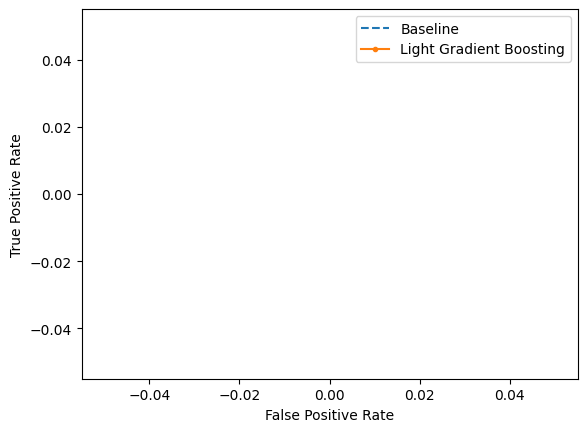

In [148]:
# model 1: LGBM
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model=GradientBoostingClassifier()
modelname='Light Gradient Boosting'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_lgb=evaluate_model()

predfile_lgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'lgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Light Gradient Descent - Default'

val_lgb=failure_samp[failure_samp['seg']=='val'][['cact']].reset_index()
val_lgb['lgb']=probs[:, 1].tolist()

#LGD=model_evaluation2()

In [151]:
#!pip install xgboost

RMSE: 0.273811
Actual       0.025075
Predicted    0.001460
dtype: float64
Actual       13278.0
Predicted      773.0
dtype: float64
Actual       0.000000
Predicted    0.074972
dtype: float64
Actual           0.0
Predicted    65771.0
dtype: float64
Confusion matrix : 
 [[516131    118]
 [ 12623    655]]
Confusion matrix : 
 [[516249      0]
 [     0  13278]]
Confusion matrix : 
 [[811499  65771]
 [     0      0]]
Confusion matrix : 
 [[877270      0]
 [     0      0]]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


Baseline: ROC AUC=nan
Xgboost: ROC AUC=nan


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


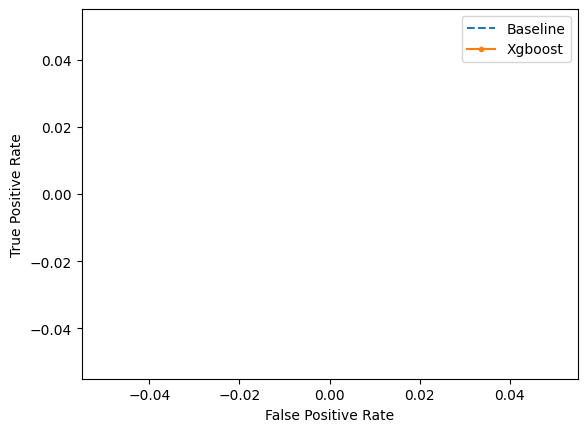

In [152]:
# model 2: XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

model= XGBClassifier()
modelname='Xgboost'

model.fit(X_train,y_train)
preds=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_xgb=evaluate_model()

predfile_xgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'xgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Default'

val_xgb=failure_samp[failure_samp['seg']=='val'][['cact', 'y']].reset_index()
val_xgb['xgb']=probs[:, 1].tolist()

#XGB=model_evaluation2()

In [153]:
predfile_xgb_nodup=val_xgb.drop_duplicates(subset='cact', keep='first')
predfile_lgb_nodup=val_lgb.drop_duplicates(subset='cact', keep='first')

predfile_xgb_lgb=pd.merge(predfile_xgb_nodup, predfile_lgb_nodup, on='cact', how='inner')
predfile_xgb_lgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877270 entries, 0 to 877269
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   index_x  877270 non-null  int64  
 1   cact     877270 non-null  float64
 2   y        877270 non-null  float64
 3   xgb      877270 non-null  float64
 4   index_y  877270 non-null  int64  
 5   lgb      877270 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 40.2 MB


In [154]:
num_bins=20
labels=list(range(20, 0, -1))

predfile_xgb_lgb['lgb_xgb3']=np.sqrt(predfile_xgb_lgb['lgb']*predfile_xgb_lgb['xgb'])
predfile_xgb_lgb['lgb_xgb_bin3']=pd.qcut(predfile_xgb_lgb['lgb_xgb3'], q=20, labels=labels)

In [155]:
deploy_file=predfile_xgb_lgb[['cact', 'lgb_xgb3']]
deploy_file.rename(columns={'lgb_xgb3': 'enroll_score'}, inplace=True)
deploy_file.sort_values(by='enroll_score', ascending=False, inplace=True)
deploy_file['dummy']=1
deploy_file['score_rank']=deploy_file['dummy'].cumsum()
deploy_file['score_tier']=(deploy_file['score_rank']/len(deploy_file))*100
deploy_file['score_tier']=deploy_file['score_tier'].astype('int')
deploy_file.drop('dummy', axis=1, inplace=True)
deploy_file.info()                    

<class 'pandas.core.frame.DataFrame'>
Index: 877270 entries, 25415 to 822807
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cact          877270 non-null  float64
 1   enroll_score  877270 non-null  float64
 2   score_rank    877270 non-null  int64  
 3   score_tier    877270 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 33.5 MB


/var/tmp/ipykernel_8825/1915072878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_file.rename(columns={'lgb_xgb3': 'enroll_score'}, inplace=True)
/var/tmp/ipykernel_8825/1915072878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_file.sort_values(by='enroll_score', ascending=False, inplace=True)
/var/tmp/ipykernel_8825/1915072878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [156]:
deploy_file.groupby('score_tier')['score_rank'].mean()

score_tier
0        4386.5
1       13159.0
2       21932.0
3       30704.5
4       39477.0
         ...   
96     846565.5
97     855338.0
98     864111.0
99     872883.5
100    877270.0
Name: score_rank, Length: 101, dtype: float64

In [157]:
# merge with opt out data
#deploy_file=pd.read_csv(str(path_name)+str('/deploy_file_20250908')+str('.csv'))
past_enroll=pd.read_csv(str(path_name)+str('/past_enroll.csv'))
past_optout=pd.read_csv(str(path_name)+str('/past_optout.csv'))
past_optout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928873 entries, 0 to 928872
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   928873 non-null  int64 
 1   latest_optout_date     928873 non-null  object
 2   last_optout_recency    928873 non-null  int64 
 3   optout_cnt_total       928873 non-null  int64 
 4   optout_cnt_lastyear    928873 non-null  int64 
 5   optout_cnt_last2years  928873 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 42.5+ MB


In [158]:
deploy_file=pd.merge(deploy_file, past_optout, on='cact', how='left')
deploy_file=pd.merge(deploy_file, past_enroll, on='cact', how='left')
deploy_file.columns.tolist()

['cact',
 'enroll_score',
 'score_rank',
 'score_tier',
 'latest_optout_date',
 'last_optout_recency',
 'optout_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years',
 'past_enroll_date',
 'past_enroll_recency',
 'enroll_cnt_total',
 'enroll_cnt_lastyear',
 'enroll_cnt_last2years']

In [159]:
deploy_file.groupby('score_tier')[['enroll_score', 'score_rank']].mean()

,enroll_score,score_rank
score_tier,,
0,0.589419,4386.5
1,0.553990,13159.0
2,0.532326,21932.0
3,0.505511,30704.5
4,0.482383,39477.0
...,...,...
96,0.023299,846565.5
97,0.019749,855338.0
98,0.016058,864111.0


In [160]:
deploy_file=pd.merge(val_resi[['bp', 'cact']], deploy_file, on='cact', how='right')

In [161]:
deploy_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877270 entries, 0 to 877269
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bp                     877270 non-null  int64  
 1   cact                   877270 non-null  int64  
 2   enroll_score           877270 non-null  float64
 3   score_rank             877270 non-null  int64  
 4   score_tier             877270 non-null  int64  
 5   latest_optout_date     268617 non-null  object 
 6   last_optout_recency    268617 non-null  float64
 7   optout_cnt_total       268617 non-null  float64
 8   optout_cnt_lastyear    268617 non-null  float64
 9   optout_cnt_last2years  268617 non-null  float64
 10  past_enroll_date       229358 non-null  object 
 11  past_enroll_recency    229358 non-null  float64
 12  enroll_cnt_total       229358 non-null  float64
 13  enroll_cnt_lastyear    229358 non-null  float64
 14  enroll_cnt_last2years  229358 non-nu

In [162]:
deploy_file=deploy_file[['bp', 'cact',
 'enroll_score',
 'score_rank',
 'score_tier',
 'latest_optout_date',
 'last_optout_recency',
 'optout_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years']]

#### The following is the deliverable list to be uploaded to Snowflake

In [163]:
deploy_file.to_csv(str(path_name)+str('/deploy_file_resi_')+str(formatted_date)+str('.csv'), index=False)

In [164]:
deploy_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 877270 entries, 0 to 877269
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bp                     877270 non-null  int64  
 1   cact                   877270 non-null  int64  
 2   enroll_score           877270 non-null  float64
 3   score_rank             877270 non-null  int64  
 4   score_tier             877270 non-null  int64  
 5   latest_optout_date     268617 non-null  object 
 6   last_optout_recency    268617 non-null  float64
 7   optout_cnt_total       268617 non-null  float64
 8   optout_cnt_lastyear    268617 non-null  float64
 9   optout_cnt_last2years  268617 non-null  float64
dtypes: float64(5), int64(4), object(1)
memory usage: 66.9+ MB


### 4.2 - Scoring for non-residential customers

In [166]:
mod=pd.read_csv(str(path_name)+str('/nonres_model_sample2.csv'))
mod.shape

/var/tmp/ipykernel_8825/2799865644.py:1: DtypeWarning: Columns (6,7,9,11,16,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  mod=pd.read_csv(str(path_name)+str('/nonres_model_sample2.csv'))


(206982, 788)

In [167]:
failure_samp=pd.concat([mod.assign(seg='mod'), val_nonresi.assign(seg='val')])
failure_samp['y'].fillna(0, inplace=True)
failure_samp.info()
failure_samp.groupby('seg').size()

<class 'pandas.core.frame.DataFrame'>
Index: 407788 entries, 0 to 1078075
Columns: 843 entries, accountclass to IBE7641_02IncomeEstimatedHousehold1003_Household4_HouseholdInferredA_Zip4G_Zip
dtypes: float64(825), int64(3), object(15)
memory usage: 2.6+ GB


/var/tmp/ipykernel_8825/538223969.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  failure_samp['y'].fillna(0, inplace=True)


seg
mod    206982
val    200806
dtype: int64

In [168]:
def trans_df(df):
    df['acct_age'].fillna(0, inplace=True)
    df['create_ca_sub_ct_360'].fillna(0, inplace=True)
    df['invce_ca_ct_360d'].fillna(0, inplace=True)
    df['create_ca_sub_ct_90'].fillna(0, inplace=True)
    df['invceZcreate_ca_ct_360d'].fillna(0, inplace=True)
    df['exempt'].fillna(-1, inplace=True)
    df['count_IN_180'].fillna(0, inplace=True)
    df['pymt_ca_ct_180d'].fillna(0, inplace=True)
    df['pymt_ca_am_60d'].fillna(-10, inplace=True)
    df['pymtZpymt_ca_ct_90d'].fillna(0, inplace=True)
    df['pymt_ca_ct_90d'].fillna(-1, inplace=True)
    df['pymt_ca_sub_am_60'].fillna(-30, inplace=True)
    df['count_AM_360'].fillna(-1, inplace=True)
    df['count_ML_180'].fillna(-2, inplace=True)
    df['pymt_ca_recency'].fillna(0, inplace=True)
    df['invceZcreate_ca_am_90d'].fillna(-100, inplace=True)
    df['pcomm_ca_recency'].fillna(0, inplace=True)
    
trans_df(failure_samp)

/var/tmp/ipykernel_8825/2192139306.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['acct_age'].fillna(0, inplace=True)
/var/tmp/ipykernel_8825/2192139306.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [169]:
 xlist=['acct_age', 'create_ca_sub_ct_360', 'invce_ca_ct_360d', 'create_ca_sub_ct_90', 
        #'invceZcreate_ca_ct_360d',
       'exempt', 'count_IN_180', 'pymt_ca_ct_180d', 'pymt_ca_am_60d', 'pymtZpymt_ca_ct_90d', 
        #'pymt_ca_ct_90d', 
       #'pymt_ca_sub_am_60', 
        'count_AM_360', 'count_ML_180', 'pymt_ca_recency', 'invceZcreate_ca_am_90d',
       'pcomm_ca_recency']

/var/tmp/ipykernel_8825/41899399.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xlist2['y']=failure_samp['y']


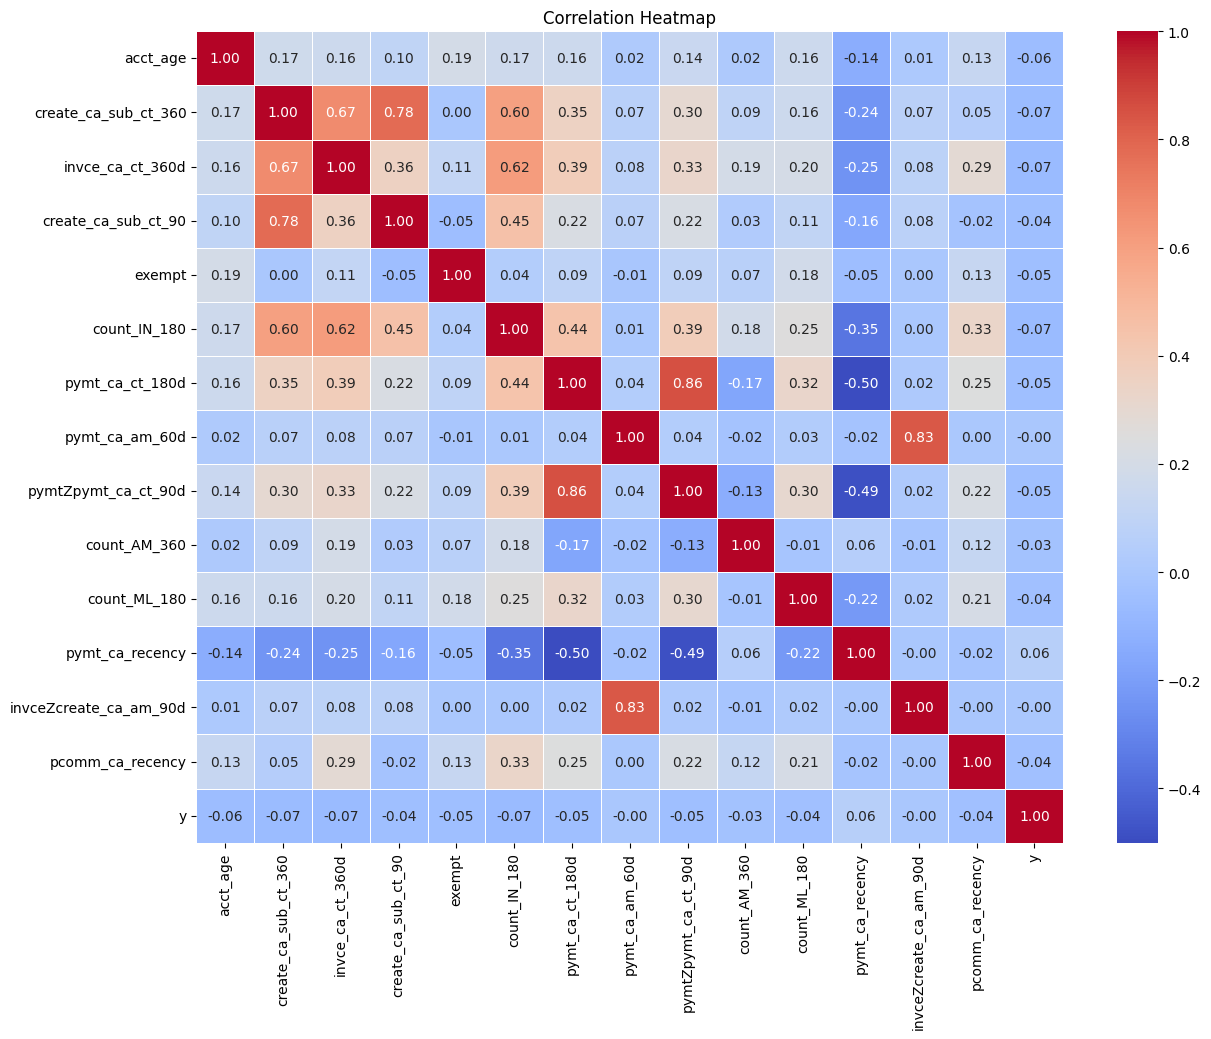

In [170]:
xlist2=failure_samp[xlist]
xlist2['y']=failure_samp['y']

correlation_matrix=xlist2.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(13, 10.5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")
plt.show()

In [171]:
X_train=failure_samp[failure_samp['seg']=='mod'][xlist]
X_test=failure_samp[failure_samp['seg']=='val'][xlist]

y_train=failure_samp[failure_samp['seg']=='mod']['y']
y_test=failure_samp[failure_samp['seg']=='val']['y']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(206982, 14)
(200806, 14)
(206982,)
(200806,)


In [172]:
X_train.isnull().sum()

acct_age                  0
create_ca_sub_ct_360      0
invce_ca_ct_360d          0
create_ca_sub_ct_90       0
exempt                    0
count_IN_180              0
pymt_ca_ct_180d           0
pymt_ca_am_60d            0
pymtZpymt_ca_ct_90d       0
count_AM_360              0
count_ML_180              0
pymt_ca_recency           0
invceZcreate_ca_am_90d    0
pcomm_ca_recency          0
dtype: int64

Actual       0.011880
Predicted    0.000203
dtype: float64
Actual       2459.0
Predicted      42.0
dtype: float64
Actual       0.000000
Predicted    0.000632
dtype: float64
Actual         0.0
Predicted    127.0
dtype: float64
Confusion matrix : 
 [[204520      3]
 [  2420     39]]
Confusion matrix : 
 [[204523      0]
 [     0   2459]]
Confusion matrix : 
 [[200679    127]
 [     0      0]]
Confusion matrix : 
 [[200806      0]
 [     0      0]]
Baseline: ROC AUC=nan
Light Gradient Boosting: ROC AUC=nan


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


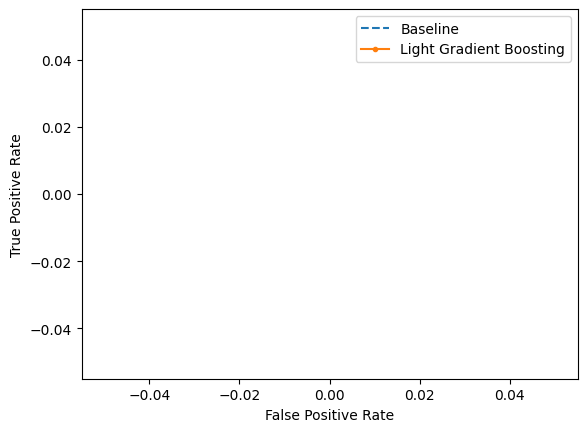

In [173]:
# Light Gradient Boosting Machine
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

model=GradientBoostingClassifier()
modelname='Light Gradient Boosting'

model.fit(X_train, y_train)

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_lgb=evaluate_model()

predfile_lgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'lgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='Light Gradient Descent - Default'

val_lgb=failure_samp[failure_samp['seg']=='val'][['cact']].reset_index()
val_lgb['lgb']=probs[:, 1].tolist()

RMSE: 0.028050
Actual       0.011880
Predicted    0.000836
dtype: float64
Actual       2459.0
Predicted     173.0
dtype: float64
Actual       0.000000
Predicted    0.000787
dtype: float64
Actual         0.0
Predicted    158.0
dtype: float64
Confusion matrix : 
 [[204511     12]
 [  2298    161]]
Confusion matrix : 
 [[204523      0]
 [     0   2459]]
Confusion matrix : 
 [[200648    158]
 [     0      0]]
Confusion matrix : 
 [[200806      0]
 [     0      0]]
Baseline: ROC AUC=nan
Xgboost: ROC AUC=nan


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1201: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


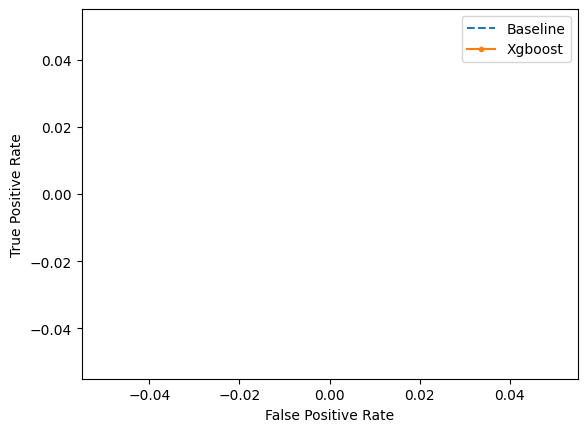

In [174]:
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error

model= XGBClassifier()
modelname='Xgboost'

model.fit(X_train,y_train)
preds=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

y_pred_mod=model.predict(X_train)
y_pred_val=model.predict(X_test)

w_xgb=evaluate_model()

predfile_xgb=pd.DataFrame({'cact': failure_samp[failure_samp['seg']=='val']['cact'], 'Predicted': y_pred_val}).rename(columns={'Predicted':'xgb'})

preds=model.predict(X_test)
probs=model.predict_proba(X_test)
actuals=y_test.reset_index(drop=True)
model_name='XGBoost - Default'

val_xgb=failure_samp[failure_samp['seg']=='val'][['cact', 'y']].reset_index()
val_xgb['xgb']=probs[:, 1].tolist()

In [175]:
predfile_xgb_nodup=val_xgb.drop_duplicates(subset='cact', keep='first')
predfile_lgb_nodup=val_lgb.drop_duplicates(subset='cact', keep='first')

predfile_xgb_lgb=pd.merge(predfile_xgb_nodup, predfile_lgb_nodup, on='cact', how='inner')
predfile_xgb_lgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200806 entries, 0 to 200805
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   index_x  200806 non-null  int64  
 1   cact     200806 non-null  int64  
 2   y        200806 non-null  float64
 3   xgb      200806 non-null  float64
 4   index_y  200806 non-null  int64  
 5   lgb      200806 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 9.2 MB


In [176]:
num_bins=20
labels=list(range(20, 0, -1))

predfile_xgb_lgb['lgb_xgb3']=np.sqrt(predfile_xgb_lgb['lgb']*predfile_xgb_lgb['xgb'])
predfile_xgb_lgb['lgb_xgb_bin3']=pd.qcut(predfile_xgb_lgb['lgb_xgb3'], q=20, labels=labels)

In [177]:
deploy_file=predfile_xgb_lgb[['cact', 'lgb_xgb3']]
deploy_file.rename(columns={'lgb_xgb3': 'enroll_score'}, inplace=True)
deploy_file.sort_values(by='enroll_score', ascending=False, inplace=True)
deploy_file['dummy']=1
deploy_file['score_rank']=deploy_file['dummy'].cumsum()
deploy_file['score_tier']=(deploy_file['score_rank']/len(deploy_file))*100
deploy_file['score_tier']=deploy_file['score_tier'].astype('int')
deploy_file.drop('dummy', axis=1, inplace=True)
deploy_file.info()                    

<class 'pandas.core.frame.DataFrame'>
Index: 200806 entries, 191935 to 97656
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cact          200806 non-null  int64  
 1   enroll_score  200806 non-null  float64
 2   score_rank    200806 non-null  int64  
 3   score_tier    200806 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 7.7 MB


/var/tmp/ipykernel_8825/1915072878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_file.rename(columns={'lgb_xgb3': 'enroll_score'}, inplace=True)
/var/tmp/ipykernel_8825/1915072878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deploy_file.sort_values(by='enroll_score', ascending=False, inplace=True)
/var/tmp/ipykernel_8825/1915072878.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [178]:
deploy_file=pd.merge(deploy_file, past_optout, on='cact', how='left')
deploy_file=pd.merge(deploy_file, past_enroll, on='cact', how='left')
deploy_file.columns.tolist()

['cact',
 'enroll_score',
 'score_rank',
 'score_tier',
 'latest_optout_date',
 'last_optout_recency',
 'optout_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years',
 'past_enroll_date',
 'past_enroll_recency',
 'enroll_cnt_total',
 'enroll_cnt_lastyear',
 'enroll_cnt_last2years']

In [179]:
deploy_file=pd.merge(val_nonresi[['bp', 'cact']], deploy_file, on='cact', how='right')

In [180]:
deploy_file=deploy_file[['bp', 'cact',
 'enroll_score',
 'score_rank',
 'score_tier',
 'latest_optout_date',
 'last_optout_recency',
 'optout_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years']]

In [181]:
deploy_file.to_csv(str(path_name)+str('/deploy_file_nonresi_')+str(formatted_date)+str('.csv'), index=False)

In [182]:
deploy_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200806 entries, 0 to 200805
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   bp                     200806 non-null  int64  
 1   cact                   200806 non-null  int64  
 2   enroll_score           200806 non-null  float64
 3   score_rank             200806 non-null  int64  
 4   score_tier             200806 non-null  int64  
 5   latest_optout_date     25190 non-null   object 
 6   last_optout_recency    25190 non-null   float64
 7   optout_cnt_total       25190 non-null   float64
 8   optout_cnt_lastyear    25190 non-null   float64
 9   optout_cnt_last2years  25190 non-null   float64
dtypes: float64(5), int64(4), object(1)
memory usage: 15.3+ MB


### Part 5 - Model performance monitoring
* The following code is to be run posterior to the cut-off date.  We need to give a window of a few days to collect enrollment results.
* For monitoring model performance, make sure to change the cut-off date to the original date when the list was generated.

In [203]:
#deploy_file=pd.read_csv(str(path_name)+str('/deploy_file_')+formatted_date+str('.csv'))
resi_file=pd.read_csv(str(path_name)+str('/deploy_file_resi_')+str(formatted_date)+str('.csv'))
nonresi_file=pd.read_csv(str(path_name)+str('/deploy_file_nonresi_')+str(formatted_date)+str('.csv'))

deploy_file=pd.concat([resi_file.assign(seg='resi'), nonresi_file.assign(seg='nonresi')])
deploy_file.groupby('seg').size()

seg
nonresi    200795
resi       875349
dtype: int64

In [204]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = current_date;

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) >= cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 
    
new_enroll=pd.DataFrame(ret)
new_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
new_enroll.info()
new_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cact                   3 non-null      object
 1   past_enroll_date       3 non-null      object
 2   past_enroll_recency    3 non-null      int64 
 3   enroll_cnt_lastyear    3 non-null      int64 
 4   enroll_cnt_last2years  3 non-null      int64 
dtypes: int64(3), object(2)
memory usage: 248.0+ bytes


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_lastyear,enroll_cnt_last2years
0,700579268078,2025-11-03,0,1,1
1,701013894261,2025-11-03,0,1,1
2,701013904769,2025-11-03,0,1,1


In [205]:
new_enroll['cact']=pd.to_numeric(new_enroll['cact'], errors='coerce')
new_enroll.drop_duplicates(subset='cact', keep='first', inplace=True)

In [206]:
# remove possibly erraneous data
print(new_enroll.shape)
new_enroll['past_enroll_dt']=pd.to_datetime(new_enroll['past_enroll_date'], errors='coerce')
new_enroll=new_enroll[new_enroll['past_enroll_dt'] != '2025-10-04']
print(new_enroll.shape)

(3, 5)
(3, 6)


In [207]:
pred_file_val=pd.merge(deploy_file, new_enroll.assign(y=1), on='cact', how='left')
pred_file_val['y'].fillna(0, inplace=True)

/var/tmp/ipykernel_5477/2561233026.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





         seg  score_tier    y
0    nonresi           0  0.0
1    nonresi           1  0.0
2    nonresi           2  0.0
3    nonresi           3  0.0
4    nonresi           4  0.0
..       ...         ...  ...
197     resi          96  0.0
198     resi          97  0.0
199     resi          98  0.0
200     resi          99  0.0
201     resi         100  0.0

[202 rows x 3 columns]


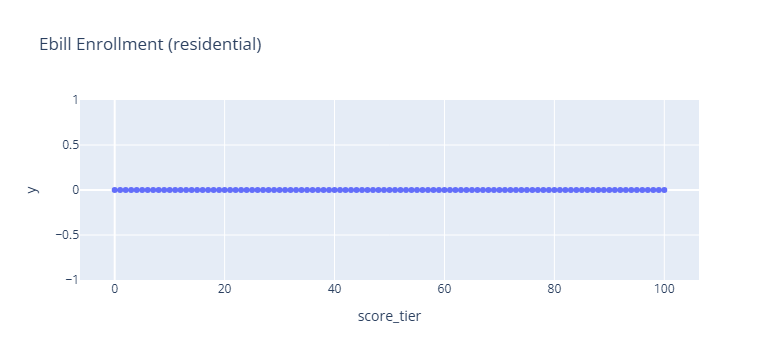

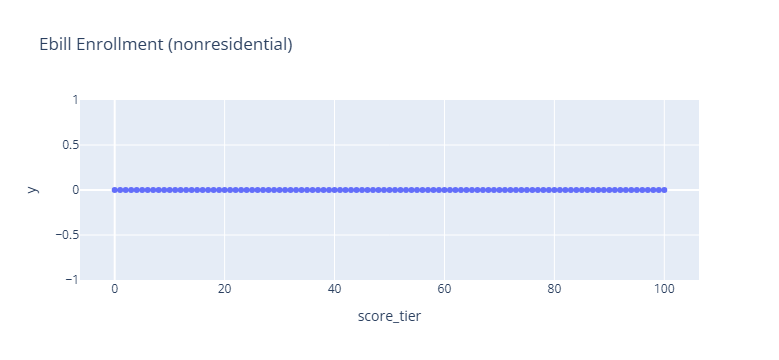

In [208]:
forline=pred_file_val.groupby(['seg', 'score_tier'])['y'].mean().reset_index()
print(forline)
fig = px.line(forline[forline['seg']=='resi'], x='score_tier', y='y', title='Ebill Enrollment (residential)', markers=True)
fig.show()

fig = px.line(forline[forline['seg']=='nonresi'], x='score_tier', y='y', title='Ebill Enrollment (nonresidential)', markers=True)
fig.show()

   Score Bin  % Enrolled  baseline
0         20         0.0       0.0
1         19         0.0       0.0
2         18         0.0       0.0
3         17         0.0       0.0
4         16         0.0       0.0
5         15         0.0       0.0
6         14         0.0       0.0
7         13         0.0       0.0
8         12         0.0       0.0
9         11         0.0       0.0
10        10         0.0       0.0
11         9         0.0       0.0
12         8         0.0       0.0
13         7         0.0       0.0
14         6         0.0       0.0
15         5         0.0       0.0
16         4         0.0       0.0
17         3         0.0       0.0
18         2         0.0       0.0
19         1         0.0       0.0


/var/tmp/ipykernel_5477/3860935501.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/tmp/ipykernel_5477/3860935501.py:9: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



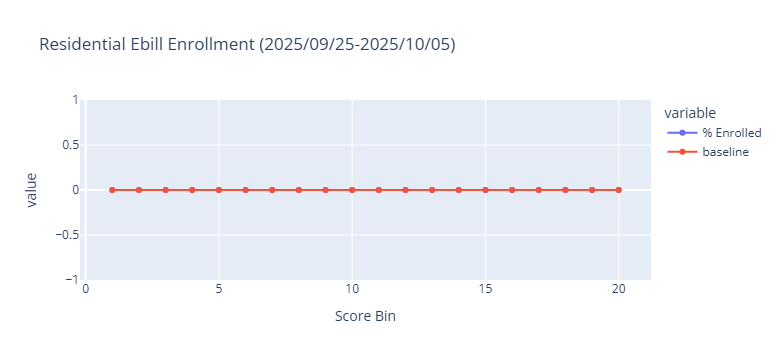

In [209]:
# Divide the score into 20 bins
num_bins=20
labels=list(range(20, 0, -1))
labels

pred_file_val2=pred_file_val[pred_file_val['seg']=='resi']
pred_file_val2['Score Bin']=pd.qcut(pred_file_val2['enroll_score'], q=20, labels=labels)

forline=pred_file_val2.groupby('Score Bin')['y'].mean().reset_index()
forline.rename(columns={'y': '% Enrolled'}, inplace=True)
forline['baseline']=pred_file_val2['y'].mean()
print(forline)
fig = px.line(forline, x='Score Bin', y=['% Enrolled', 'baseline'], title='Residential Ebill Enrollment (2025/09/25-2025/10/05)', 
              markers=True)
fig.show()

   Score Bin  % Enrolled  baseline
0         20         0.0       0.0
1         19         0.0       0.0
2         18         0.0       0.0
3         17         0.0       0.0
4         16         0.0       0.0
5         15         0.0       0.0
6         14         0.0       0.0
7         13         0.0       0.0
8         12         0.0       0.0
9         11         0.0       0.0
10        10         0.0       0.0
11         9         0.0       0.0
12         8         0.0       0.0
13         7         0.0       0.0
14         6         0.0       0.0
15         5         0.0       0.0
16         4         0.0       0.0
17         3         0.0       0.0
18         2         0.0       0.0
19         1         0.0       0.0


/var/tmp/ipykernel_5477/2762968811.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/tmp/ipykernel_5477/2762968811.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



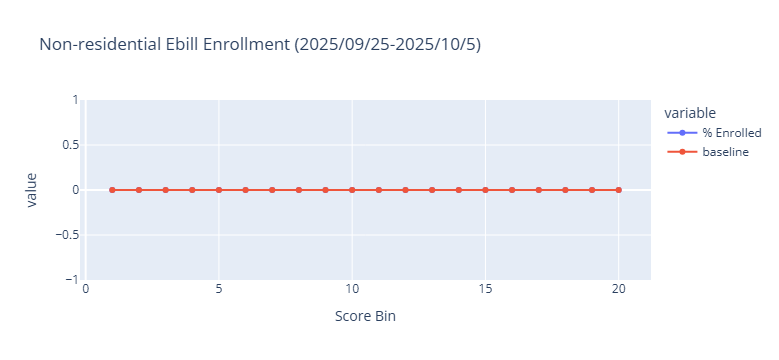

In [210]:
num_bins=20
labels=list(range(20, 0, -1))
labels

pred_file_val2=pred_file_val[pred_file_val['seg']=='nonresi']
pred_file_val2['Score Bin']=pd.qcut(pred_file_val2['enroll_score'], q=20, labels=labels)

forline=pred_file_val2.groupby('Score Bin')['y'].mean().reset_index()
forline.rename(columns={'y': '% Enrolled'}, inplace=True)
forline['baseline']=pred_file_val2['y'].mean()
print(forline)
fig = px.line(forline, x='Score Bin', y=['% Enrolled', 'baseline'], title='Non-residential Ebill Enrollment (2025/09/25-2025/10/5)', 
              markers=True)
fig.show()

In [211]:

notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE =  current_date;

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) >= cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 
    
new_enroll=pd.DataFrame(ret)
new_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
new_enroll.info()
new_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   cact                   3 non-null      object
 1   past_enroll_date       3 non-null      object
 2   past_enroll_recency    3 non-null      int64 
 3   enroll_cnt_lastyear    3 non-null      int64 
 4   enroll_cnt_last2years  3 non-null      int64 
dtypes: int64(3), object(2)
memory usage: 248.0+ bytes


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_lastyear,enroll_cnt_last2years
0,700579268078,2025-11-03,0,1,1
1,701013894261,2025-11-03,0,1,1
2,701013904769,2025-11-03,0,1,1


In [212]:
new_enroll.groupby('past_enroll_date').size()

past_enroll_date
2025-11-03    3
dtype: int64